# Get Started

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf

In [ ]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

# from utils import *

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

### Load the data

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
uploaded  = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 1
!kaggle competitions download -c super-ai-engineer-2021-house-grade-classification
!unzip -q super-ai-engineer-2021-house-grade-classification.zip -d /content/house-grade-classification
# 2
!kaggle competitions download -c super-ai-engineer-2021-properties-tagging
!unzip -q super-ai-engineer-2021-properties-tagging.zip -d /content/properties-tagging
# replace sample_submission.csv? : y
# replace train.csv? : y

100% 2.31G/2.31G [00:09<00:00, 213MB/s]
100% 2.31G/2.31G [00:09<00:00, 251MB/s]
100% 4.04G/4.05G [00:59<00:00, 101MB/s] 
100% 4.05G/4.05G [00:59<00:00, 73.3MB/s]


# Get the data

### get the csv file

In [ ]:
df = pd.read_csv("/content/properties-tagging/extra.csv")
df.insert(loc=1, column="path", value=list(df['filename'].apply(lambda x: "/content/properties-tagging/extra/" + x)))
df

filename  \
0     MrtSutthisan_img_13-7802206_100-5717337_a257_s...   
1     MrtSutthisan_img_13-7802824_100-5717195_a3_s90...   
2     MrtSutthisan_img_13-7803048_100-5713201_a183_s...   
3     MrtSutthisan_img_13-7813255_100-5697035_a183_s...   
4     MrtSutthisan_img_13-7813311_100-5696037_a183_s...   
...                                                 ...   
5883  img_13-7643371_100-539753_a30-82040882_s300-82...   
5884  img_13-7667727_100-5356214_a25-41138042_s115-4...   
5885  img_13-7667727_100-5356214_a25-41138042_s295-4...   
5886  img_13-7670169_100-5357421_a25-40547316_s115-4...   
5887  img_13-7670169_100-5357421_a25-40547316_s295-4...   

                                                   path labels  
0     /content/properties-tagging/extra/MrtSutthisan...      0  
1     /content/properties-tagging/extra/MrtSutthisan...      0  
2     /content/properties-tagging/extra/MrtSutthisan...      0  
3     /content/properties-tagging/extra/MrtSutthisan...      0  
4     /content/properties-tagging/extra/MrtSutthisan...      3  
...                                                 ...    ...  
5883  /content/properties-tagging/extra/img_13-76433...      3  
5884  /content/properties-tagging/extra/img_13-76677...      0  
5885  /content/properties-tagging/extra/img_13-76677...      3  
5886  /content/properties-tagging/extra/img_13-76701...    2 3  
5887  /content/properties-tagging/extra/img_13-76701...      0  

[5888 rows x 3 columns]

In [ ]:
os.listdir("/content/properties-tagging/extra")[:5]

['img_13-7736953_100-5587186_a101-7287872_s191-7287872_y0_f90_1.jpg',
 'img_13-8207785_100-6022528_a257-3723435_s167-37234349999994_y0_f90_1.jpg',
 'img_13-8134692_100-5870512_a130-5147476_s40-514747599999964_y0_f90_1.jpg',
 'img_13-7858514_100-584906_a92-28498321_s182-28498321_y0_f90_1.jpg',
 'img_13-799666_100-5774481_a352-2802765_s82-28027650000001_y0_f90_1.jpg']

### see some picture

In [ ]:
path = "/content/properties-tagging/extra/"

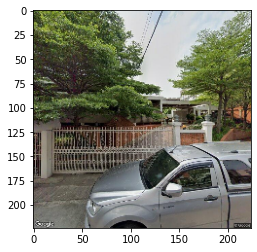

In [ ]:
from google.colab.patches import cv2_imshow

im = cv2.imread(path + os.listdir("/content/properties-tagging/extra")[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)

#cv2_imshow(im)
plt.imshow(im)
plt.show()

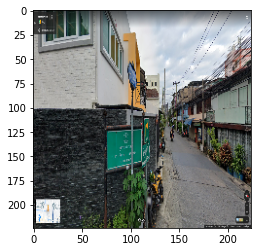

In [ ]:
im = cv2.imread(df.loc[0, 'path'])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)

#cv2_imshow(im)
plt.imshow(im)
plt.show()

# Data Preprocessing

### one-hot the labels

In [ ]:
df.head(10)

filename  \
0  MrtSutthisan_img_13-7802206_100-5717337_a257_s...   
1  MrtSutthisan_img_13-7802824_100-5717195_a3_s90...   
2  MrtSutthisan_img_13-7803048_100-5713201_a183_s...   
3  MrtSutthisan_img_13-7813255_100-5697035_a183_s...   
4  MrtSutthisan_img_13-7813311_100-5696037_a183_s...   
5  MrtSutthisan_img_13-7813311_100-5696037_a3_s90...   
6  MrtSutthisan_img_13-7813367_100-5695038_a183_s...   
7  MrtSutthisan_img_13-7813367_100-5695038_a3_s90...   
8  MrtSutthisan_img_13-7813423_100-569404_a3_s90_...   
9  MrtSutthisan_img_13-7813479_100-5693041_a3_s90...   

                                                path labels  
0  /content/properties-tagging/extra/MrtSutthisan...      0  
1  /content/properties-tagging/extra/MrtSutthisan...      0  
2  /content/properties-tagging/extra/MrtSutthisan...      0  
3  /content/properties-tagging/extra/MrtSutthisan...      0  
4  /content/properties-tagging/extra/MrtSutthisan...      3  
5  /content/properties-tagging/extra/MrtSutthisan...      0  
6  /content/properties-tagging/extra/MrtSutthisan...  2 3 5  
7  /content/properties-tagging/extra/MrtSutthisan...      0  
8  /content/properties-tagging/extra/MrtSutthisan...      0  
9  /content/properties-tagging/extra/MrtSutthisan...      0

In [ ]:
df['labels'] = df['labels'].apply(lambda x:str(x))

In [ ]:
df_dummies = df['labels'].str.get_dummies(sep=' ')
df_dummies.head(10)

0  1  2  3  4  5
0  1  0  0  0  0  0
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  0  0  0  1  0  0
5  1  0  0  0  0  0
6  0  0  1  1  0  1
7  1  0  0  0  0  0
8  1  0  0  0  0  0
9  1  0  0  0  0  0

In [ ]:
df = pd.concat([df, df_dummies], axis=1)
df.head(10)

filename  \
0  MrtSutthisan_img_13-7802206_100-5717337_a257_s...   
1  MrtSutthisan_img_13-7802824_100-5717195_a3_s90...   
2  MrtSutthisan_img_13-7803048_100-5713201_a183_s...   
3  MrtSutthisan_img_13-7813255_100-5697035_a183_s...   
4  MrtSutthisan_img_13-7813311_100-5696037_a183_s...   
5  MrtSutthisan_img_13-7813311_100-5696037_a3_s90...   
6  MrtSutthisan_img_13-7813367_100-5695038_a183_s...   
7  MrtSutthisan_img_13-7813367_100-5695038_a3_s90...   
8  MrtSutthisan_img_13-7813423_100-569404_a3_s90_...   
9  MrtSutthisan_img_13-7813479_100-5693041_a3_s90...   

                                                path labels  0  1  2  3  4  5  
0  /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0  0  
1  /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0  0  
2  /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0  0  
3  /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0  0  
4  /content/properties-tagging/extra/MrtSutthisan...      3  0  0  0  1  0  0  
5  /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0  0  
6  /content/properties-tagging/extra/MrtSutthisan...  2 3 5  0  0  1  1  0  1  
7  /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0  0  
8  /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0  0  
9  /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0  0

# Exploratory Data Analysis

- 1 = มีกล้องวงจรปิด 
- 2 = มีที่จอดรถที่มีหลังคา
- 3 = มีรถ-มีรถอยู่ในบ้าน
- 4 = มีศาลพระภูมิ
- 5 = มีสวน-สนามหญ้า
- ถ้าไม่มี ใส่ 0

[3339, 44, 646, 2172, 163, 197]


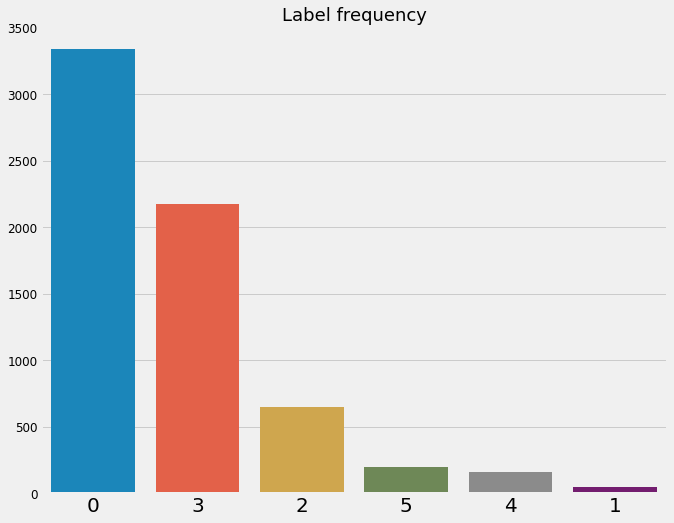

In [ ]:
# Get label frequencies in descending order
class_0 = len(df[df['0'] == 1])
class_1 = len(df[df['1'] == 1])
class_2 = len(df[df['2'] == 1])
class_3 = len(df[df['3'] == 1])
class_4 = len(df[df['4'] == 1])
class_5 = len(df[df['5'] == 1])
label_freq = [class_0, class_1, class_2, class_3, class_4, class_5]
print(label_freq)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(10,8))
sns.barplot(y=label_freq, x=[0,1,2,3,4,5], order=[0,3,2,5,4,1])
plt.title("Label frequency", fontsize=18)
plt.xlabel("")
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.show()

[]

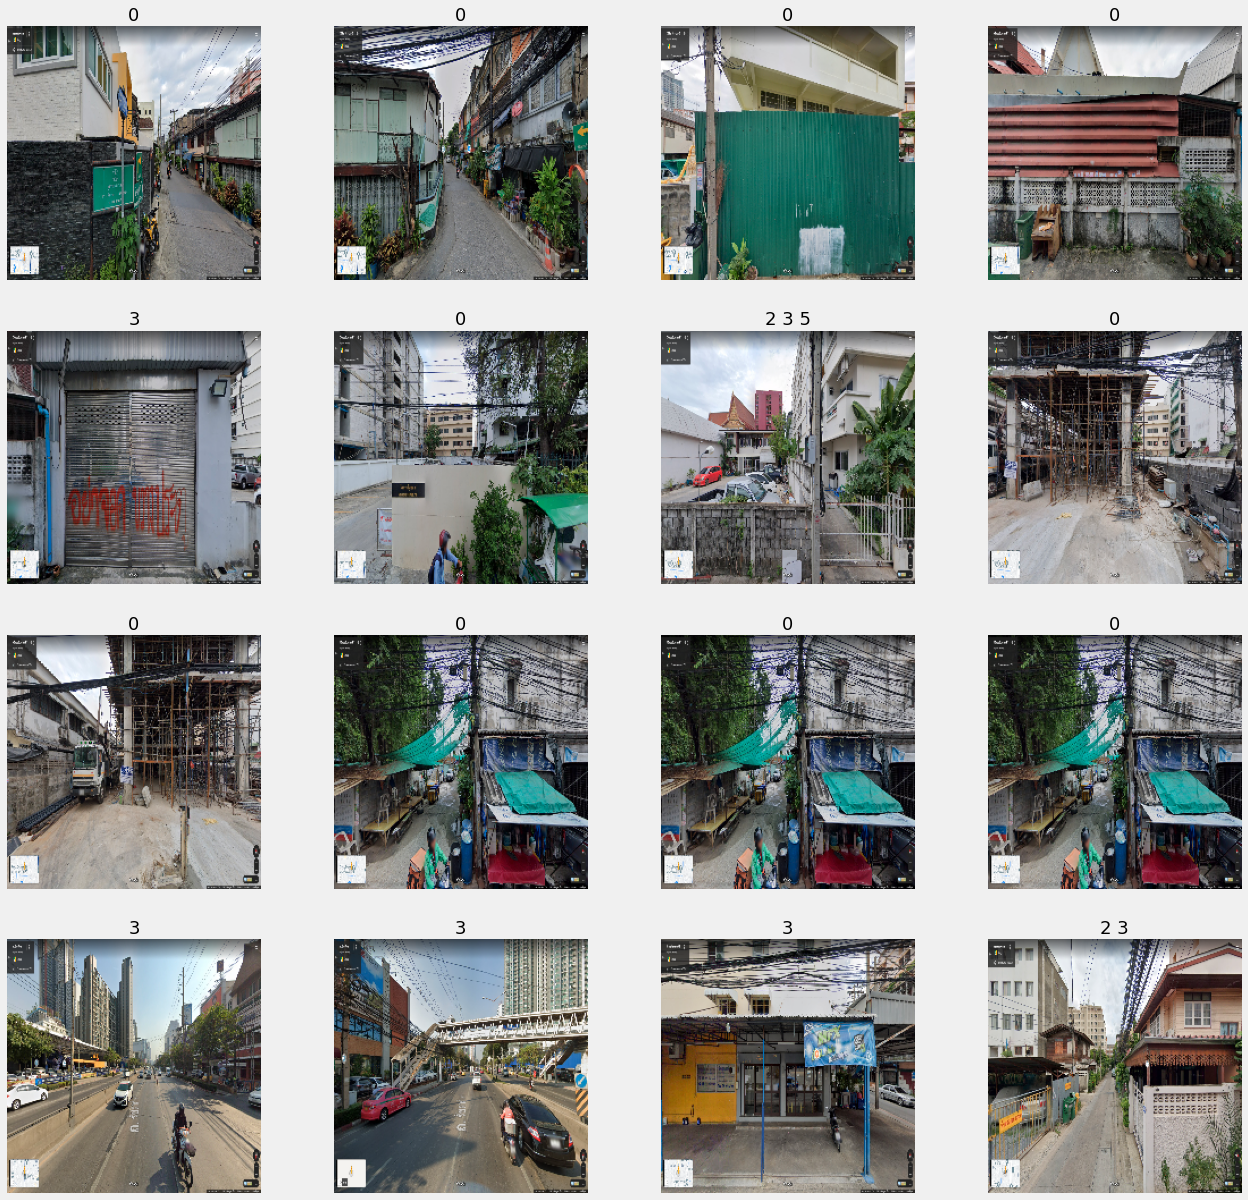

In [ ]:
ncols = 4 # Number of columns in display
nrows = 4 # Number of rows in display

sns.set_context("talk")
fig, ax = plt.subplots(nrows, ncols, figsize=(20,20))
count = 0 # the beginning of the picture you want

for i in range(nrows):
  for j in range(ncols):
    img = cv2.imread(df.loc[count, 'path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
    ax[i,j].set_axis_off()
    ax[i,j].axis('off')
    ax[i,j].imshow(img)
    ax[i,j].set_title(df.loc[count, 'labels'])
    count = count + 1

plt.plot()

[]

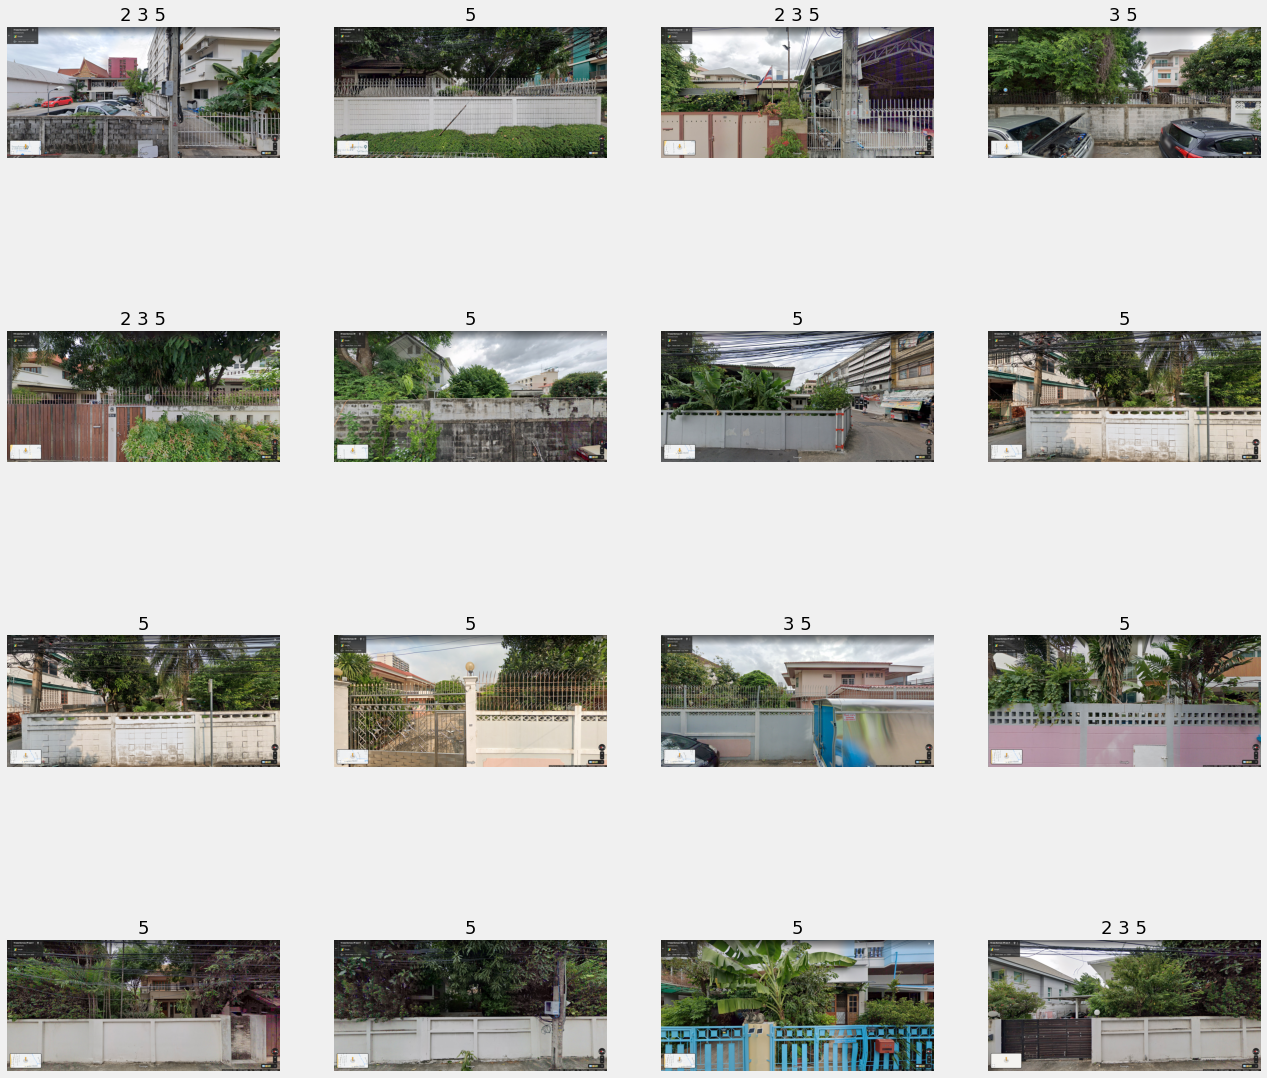

In [ ]:
ncols = 4 # Number of columns in display
nrows = 4 # Number of rows in display

sns.set_context("talk")
fig, ax = plt.subplots(nrows, ncols, figsize=(20,20))
count = 0

df_class_5 = df[df['5'] == 1]

for i in range(nrows):
  for j in range(ncols):
    img = cv2.imread(df_class_5.iloc[count]['path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
    ax[i,j].set_axis_off()
    ax[i,j].axis('off')
    ax[i,j].imshow(img)
    ax[i,j].set_title(df_class_5.iloc[count]['labels'])
    count = count + 1

plt.plot()

# Train test data

In [ ]:
  from tqdm import tqdm

train_image = []

for i in tqdm(range(df.shape[0])):
    img = image.load_img(df.loc[i, 'path'], target_size=(299,299,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)

X = np.array(train_image)

100%|██████████| 5888/5888 [01:29<00:00, 65.45it/s] 


In [ ]:
X.shape

(5888, 299, 299, 3)

(-0.5, 298.5, 298.5, -0.5)

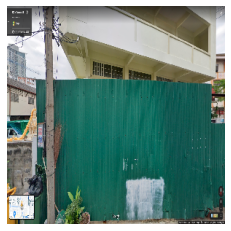

In [ ]:
plt.imshow(X[2])
plt.axis('off')

In [ ]:
y = np.array(df.drop(['filename', 'path', 'labels'],axis=1))
y.shape

(5888, 6)

In [ ]:
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [1, 0, 0, 0, 0, 0]])

### Assume the validation set

In [ ]:
import random

shuffle = []
for i in range(len(df)):
  shuffle.append(i)
random.shuffle(shuffle)
shuffle[:1000]

In [ ]:
from tqdm import tqdm

validation_image = []

for i in tqdm(shuffle[:1000]):
    img = image.load_img(df.loc[i, 'path'], target_size=(299,299,3))
    img = image.img_to_array(img)
    img = img/255
    validation_image.append(img)

X = np.array(validation_image)

100%|██████████| 1000/1000 [00:16<00:00, 59.92it/s]


In [ ]:
X.shape

(1000, 299, 299, 3)

In [ ]:
label_test = df.loc[shuffle[:1000]]
label_test.drop(columns=['filename', 'path', 'labels'], axis=1, inplace=True)
label_test

0  1  2  3  4  5
1797  1  0  0  0  0  0
4979  1  0  0  0  0  0
1776  0  0  0  0  0  1
226   1  0  0  0  0  0
4481  0  0  0  1  0  0
...  .. .. .. .. .. ..
4859  0  0  0  1  0  0
659   0  0  0  0  0  1
365   0  0  0  1  0  0
4032  1  0  0  0  0  0
4928  0  0  1  1  0  0

[1000 rows x 6 columns]

In [ ]:
y = label_test.values
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0]])

In [ ]:
len(y)

1000

### train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15, shuffle=True)

# Model

not use

In [ ]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(400,400,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='sigmoid'))

### InceptionV3

In [ ]:
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor

from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

In [ ]:
base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape=(299, 299, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(6, activation='sigmoid')(x)

In [ ]:
model = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(Adam(lr=.0001), loss='bce', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, verbose=1, batch_size=16)

Epoch 1/5
313/313 [==============================] - 619s 2s/step - loss: 1.3408 - accuracy: 0.6859 - val_loss: 1.4382 - val_accuracy: 0.6946
Epoch 2/5
313/313 [==============================] - 614s 2s/step - loss: 1.4121 - accuracy: 0.7134 - val_loss: 1.8015 - val_accuracy: 0.6980
Epoch 3/5
313/313 [==============================] - 612s 2s/step - loss: 1.6338 - accuracy: 0.6992 - val_loss: 2.0177 - val_accuracy: 0.6697
Epoch 4/5
313/313 [==============================] - 615s 2s/step - loss: 1.8360 - accuracy: 0.7054 - val_loss: 2.1894 - val_accuracy: 0.6403
Epoch 5/5
313/313 [==============================] - 619s 2s/step - loss: 1.6781 - accuracy: 0.6988 - val_loss: 1.8765 - val_accuracy: 0.6980


### save model

In [ ]:
model.save("/content/drive/MyDrive/PiceFolder/Hack 5/InceptionV3-5ep.h5")

### load model

In [ ]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/PiceFolder/Hack 5/inceptionv3/InceptionV3-5ep.h5")

# Prediction

### try some prediction

In [ ]:
df.head(20)

filename  \
0   MrtSutthisan_img_13-7802206_100-5717337_a257_s...   
1   MrtSutthisan_img_13-7802824_100-5717195_a3_s90...   
2   MrtSutthisan_img_13-7803048_100-5713201_a183_s...   
3   MrtSutthisan_img_13-7813255_100-5697035_a183_s...   
4   MrtSutthisan_img_13-7813311_100-5696037_a183_s...   
5   MrtSutthisan_img_13-7813311_100-5696037_a3_s90...   
6   MrtSutthisan_img_13-7813367_100-5695038_a183_s...   
7   MrtSutthisan_img_13-7813367_100-5695038_a3_s90...   
8   MrtSutthisan_img_13-7813423_100-569404_a3_s90_...   
9   MrtSutthisan_img_13-7813479_100-5693041_a3_s90...   
10  MrtSutthisan_img_13-7813535_100-5692043_a3_s90...   
11  MrtSutthisan_img_13-7813648_100-5690046_a3_s90...   
12  MrtSutthisan_img_13-7816157_100-5736872_a169_s...   
13  MrtSutthisan_img_13-7816157_100-5736872_a349_s...   
14  MrtSutthisan_img_13-7828547_100-5670825_a355_s...   
15  MrtSutthisan_img_13-7832129_100-5720625_a265_s...   
16  MrtSutthisan_img_13-7832129_100-5720625_a85_s9...   
17  MrtSutthisan_img_13-783303_100-5722758_a263_s9...   
18  MrtSutthisan_img_13-783303_100-5722758_a83_s27...   
19  MrtSutthisan_img_13-7833126_100-5720545_a265_s...   

                                                 path labels  0  1  2  3  4  5  
0   /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0  0  
1   /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0  0  
2   /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0  0  
3   /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0  0  
4   /content/properties-tagging/extra/MrtSutthisan...      3  0  0  0  1  0  0  
5   /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0  0  
6   /content/properties-tagging/extra/MrtSutthisan...  2 3 5  0  0  1  1  0  1  
7   /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0  0  
8   /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0  0  
9   /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0  0  
10  /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0  0  
11  /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0  0  
12  /content/properties-tagging/extra/MrtSutthisan...      3  0  0  0  1  0  0  
13  /content/properties-tagging/extra/MrtSutthisan...      3  0  0  0  1  0  0  
14  /content/properties-tagging/extra/MrtSutthisan...      3  0  0  0  1  0  0  
15  /content/properties-tagging/extra/MrtSutthisan...    2 3  0  0  1  1  0  0  
16  /content/properties-tagging/extra/MrtSutthisan...      4  0  0  0  0  1  0  
17  /content/properties-tagging/extra/MrtSutthisan...    2 3  0  0  1  1  0  0  
18  /content/properties-tagging/extra/MrtSutthisan...      4  0  0  0  0  1  0  
19  /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0  0

In [ ]:
img = cv2.imread(df.loc[15, 'path'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (299, 299), interpolation=cv2.INTER_LINEAR)
img = img/255

Text(0.5, 1.0, '2 3')

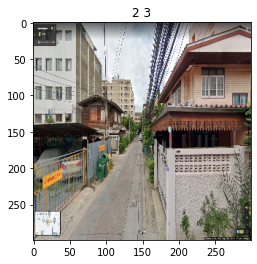

In [ ]:
plt.imshow(img)
plt.title(df.loc[15, 'labels'])

In [ ]:
loaded_model.predict(img.reshape(1,299,299,3))

array([[7.3988956e-01, 2.5214604e-24, 6.7807272e-02, 1.9078636e-01,
        1.5167344e-03, 4.4955744e-08]], dtype=float32)

<hr>

In [ ]:
img = cv2.imread(df.loc[16, 'path'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (299, 299), interpolation=cv2.INTER_LINEAR)
img = img/255

Text(0.5, 1.0, '4')

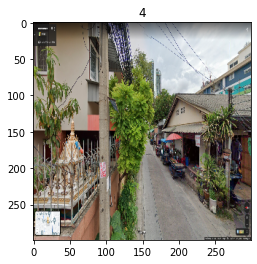

In [ ]:
plt.imshow(img)
plt.title(df.loc[16, 'labels'])

In [ ]:
np.argmax(model.predict(img.reshape(1,299,299,3)))

4

In [ ]:
np.argmax(loaded_model.predict(img.reshape(1,299,299,3)))

4

<hr>

[[6.9299781e-01 1.7810905e-23 6.6651270e-02 2.3821075e-01 2.1401490e-03
  5.3602648e-08]]
0


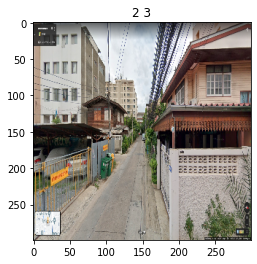

In [ ]:
img = cv2.imread(df.loc[17, 'path'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (299, 299), interpolation=cv2.INTER_LINEAR)
img = img/255

plt.imshow(img)
plt.title(df.loc[17, 'labels'])

print(loaded_model.predict(img.reshape(1,299,299,3)))
print(np.argmax(loaded_model.predict(img.reshape(1,299,299,3))))

### Try some validation data

In [ ]:
def return_class(label): # label = [1,0,1,0,0,0]
  class_label = ""
  for i in range(6):
    if label[i] == 1:
      class_label = class_label + " " + str(i)
  return class_label[1:]

def plot_pic(img):
  plt.imshow(img)
  plt.axis('off')
  plt.plot()

def prediction(img, label):
  print("Probability of all classes are {}".format(loaded_model.predict(img.reshape(1,299,299,3))))
  print("The max prob is class {}".format(np.argmax(loaded_model.predict(img.reshape(1,299,299,3)))))
  print("The actual label is {}".format(return_class(label)))
  answer = condition_label(loaded_model.predict(img.reshape(1,299,299,3)))
  print("The predicted label is {}".format(answer))
  # plot_pic(img)
  return answer
  # plt.title(return_class(label))

def condition_label(predicted):
  check = []
  if predicted[0][2] >= 3e-1:
    check.append(2)
  if predicted[0][3] >= 3e-1:
    check.append(3)
  if predicted[0][4] >= 1e-1:
    check.append(4)
  if predicted[0][5] >= 1e-4:
    check.append(5)

  #print("check = {}".format(check))

  if check is not None:
    ans = ""
    for i in check:
      ans = ans + str(i) + " "
    ans = ans[:-1]
  if ans == "":
    ans = "0"
  #print(ans)
  
  return ans

##### a bit prediction

Probability of all classes are [[6.3128799e-01 1.3958110e-22 4.2815719e-02 3.2184052e-01 4.0550847e-03
  6.7230303e-07]]
The max prob is class 0
The actual label is 3


'3'

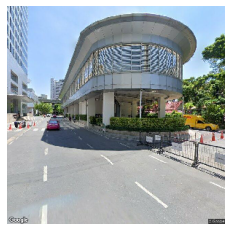

In [ ]:
prediction(X[4], y[4])

Probability of all classes are [[1.8110707e-01 1.7343318e-22 4.9077001e-01 3.2477537e-01 3.3025467e-03
  4.4962027e-05]]
The max prob is class 2
The actual label is 2 3


'2 3'

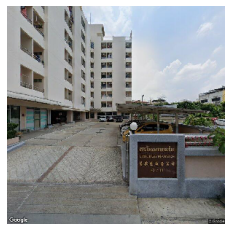

In [ ]:
prediction(X[5], y[5])

Probability of all classes are [[9.6747196e-01 2.7569447e-22 1.9356037e-02 1.1138327e-02 1.2594102e-03
  7.7419711e-04]]
The max prob is class 0
The actual label is 5


'5'

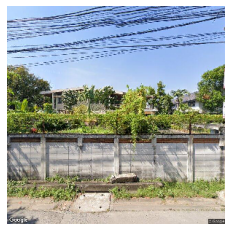

In [ ]:
prediction(X[2], y[2])

##### all validation set

In [ ]:
label_test = df.loc[shuffle[:1000]]
label_test.head()

filename  \
1797  img_13-8266913_100-5781409_a81-50671055_s171-5...   
4979  img_13-7720366_100-6265796_a260-3464568_s350-3...   
1776  img_13-825926_100-5803532_a171-9407768_s261-94...   
226   MrtSutthisan_img_13-7917028_100-5661474_a99_s9...   
4481  img_13-7464521000372_100-537930199824_s90_f90_...   

                                                   path labels  0  1  2  3  4  \
1797  /content/properties-tagging/extra/img_13-82669...      0  1  0  0  0  0   
4979  /content/properties-tagging/extra/img_13-77203...      0  1  0  0  0  0   
1776  /content/properties-tagging/extra/img_13-82592...      5  0  0  0  0  0   
226   /content/properties-tagging/extra/MrtSutthisan...      0  1  0  0  0  0   
4481  /content/properties-tagging/extra/img_13-74645...      3  0  0  0  1  0   

      5  
1797  0  
4979  0  
1776  1  
226   0  
4481  0

In [ ]:
from tqdm import tqdm
y_all = []
for i in tqdm(range(1000)):
  predicted = prediction(X[i], y[i])
  print()
  y_all.append(predicted)

100%|██████████| 1000/1000 [01:00<00:00, 16.46it/s]


In [ ]:
label_test.insert(loc=3, column='predicted', value=y_all)
label_test.head()

filename  \
1797  img_13-8266913_100-5781409_a81-50671055_s171-5...   
4979  img_13-7720366_100-6265796_a260-3464568_s350-3...   
1776  img_13-825926_100-5803532_a171-9407768_s261-94...   
226   MrtSutthisan_img_13-7917028_100-5661474_a99_s9...   
4481  img_13-7464521000372_100-537930199824_s90_f90_...   

                                                   path labels predicted  0  \
1797  /content/properties-tagging/extra/img_13-82669...      0         3  1   
4979  /content/properties-tagging/extra/img_13-77203...      0         0  1   
1776  /content/properties-tagging/extra/img_13-82592...      5         5  0   
226   /content/properties-tagging/extra/MrtSutthisan...      0         0  1   
4481  /content/properties-tagging/extra/img_13-74645...      3         3  0   

      1  2  3  4  5  
1797  0  0  0  0  0  
4979  0  0  0  0  0  
1776  0  0  0  0  1  
226   0  0  0  0  0  
4481  0  0  1  0  0

In [ ]:
validation_result = label_test.loc[:, ['labels','predicted']]

In [ ]:
validation_result.to_csv("/content/drive/MyDrive/PiceFolder/Hack 5/inceptionv3/validation_result.csv")

### make confusion matrix V.1

In [ ]:
labels = validation_result['labels'].values
predicted = validation_result['predicted'].values

In [ ]:
np.unique(labels)

array(['0', '1', '1 2 3', '2', '2 3', '2 3 4', '2 3 5', '3', '3 4', '3 5',
       '4', '4 5', '5'], dtype=object)

In [ ]:
np.unique(predicted)

array(['0', '2', '2 3', '2 3 4 5', '2 5', '3', '3 5', '4 5', '5'],
      dtype=object)

change label and predicted to onehot

In [ ]:
validation_result

labels predicted
1797      0         3
4979      0         0
1776      5         5
226       0         0
4481      3         3
...     ...       ...
4859      3         3
659       5         5
365       3         3
4032      0         0
4928    2 3         3

[1000 rows x 2 columns]

In [ ]:
df_y = pd.DataFrame(validation_result.loc[:,'labels'], columns=['labels'])
df_y['labels'] = df_y['labels'].apply(lambda x:str(x))
df_dummies_labels = pd.get_dummies(df_y['labels'])
df_dummies_labels.head()

0  1  1 2 3  2  2 3  2 3 4  2 3 5  3  3 4  3 5  4  4 5  5
1797  1  0      0  0    0      0      0  0    0    0  0    0  0
4979  1  0      0  0    0      0      0  0    0    0  0    0  0
1776  0  0      0  0    0      0      0  0    0    0  0    0  1
226   1  0      0  0    0      0      0  0    0    0  0    0  0
4481  0  0      0  0    0      0      0  1    0    0  0    0  0

In [ ]:
df_pred = pd.DataFrame(data=validation_result.loc[:,'predicted'].values, columns=['pred'])
df_pred['pred'] = df_pred['pred'].apply(lambda x:str(x))
#df_pred
df_dummies_pred = pd.get_dummies(df_pred['pred'])
df_dummies_pred.head()

0  2  2 3  2 3 4 5  2 5  3  3 5  4 5  5
0  0  0    0        0    0  1    0    0  0
1  1  0    0        0    0  0    0    0  0
2  0  0    0        0    0  0    0    0  1
3  1  0    0        0    0  0    0    0  0
4  0  0    0        0    0  1    0    0  0

In [ ]:
# เพิ่มให้ cols เท่ากัน
df_dummies_labels['2 3 4 5'] = 0
df_dummies_labels['2 5'] = 0
df_dummies_labels.head()

0  1  1 2 3  2  2 3  2 3 4  2 3 5  3  3 4  3 5  4  4 5  5  2 3 4 5  2 5
1797  1  0      0  0    0      0      0  0    0    0  0    0  0        0    0
4979  1  0      0  0    0      0      0  0    0    0  0    0  0        0    0
1776  0  0      0  0    0      0      0  0    0    0  0    0  1        0    0
226   1  0      0  0    0      0      0  0    0    0  0    0  0        0    0
4481  0  0      0  0    0      0      0  1    0    0  0    0  0        0    0

In [ ]:
df_dummies_pred['1'] = 0
df_dummies_pred['1 2 3'] = 0
df_dummies_pred['2 3 4'] = 0
df_dummies_pred['2 3 5'] = 0
df_dummies_pred['3 4'] = 0
df_dummies_pred['4'] = 0
df_dummies_pred.head()

0  2  2 3  2 3 4 5  2 5  3  3 5  4 5  5  1  1 2 3  2 3 4  2 3 5  3 4  4
0  0  0    0        0    0  1    0    0  0  0      0      0      0    0  0
1  1  0    0        0    0  0    0    0  0  0      0      0      0    0  0
2  0  0    0        0    0  0    0    0  1  0      0      0      0    0  0
3  1  0    0        0    0  0    0    0  0  0      0      0      0    0  0
4  0  0    0        0    0  1    0    0  0  0      0      0      0    0  0

In [ ]:
#df = df.reindex(sorted(df.columns), axis=1)
df_dummies_labels = df_dummies_labels.reindex(sorted(df_dummies_labels.columns), axis=1)
df_dummies_pred = df_dummies_pred.reindex(sorted(df_dummies_pred.columns), axis=1)

In [ ]:
df_dummies_labels.head()

0  1  1 2 3  2  2 3  2 3 4  2 3 4 5  2 3 5  2 5  3  3 4  3 5  4  4 5  5
1797  1  0      0  0    0      0        0      0    0  0    0    0  0    0  0
4979  1  0      0  0    0      0        0      0    0  0    0    0  0    0  0
1776  0  0      0  0    0      0        0      0    0  0    0    0  0    0  1
226   1  0      0  0    0      0        0      0    0  0    0    0  0    0  0
4481  0  0      0  0    0      0        0      0    0  1    0    0  0    0  0

In [ ]:
df_dummies_pred.head()

0  1  1 2 3  2  2 3  2 3 4  2 3 4 5  2 3 5  2 5  3  3 4  3 5  4  4 5  5
0  0  0      0  0    0      0        0      0    0  1    0    0  0    0  0
1  1  0      0  0    0      0        0      0    0  0    0    0  0    0  0
2  0  0      0  0    0      0        0      0    0  0    0    0  0    0  1
3  1  0      0  0    0      0        0      0    0  0    0    0  0    0  0
4  0  0      0  0    0      0        0      0    0  1    0    0  0    0  0

In [ ]:
y_actual = df_dummies_labels.values
y_pred = df_dummies_pred.values

In [ ]:
columns = df_dummies_labels.columns
columns

Index(['0', '1', '1 2 3', '2', '2 3', '2 3 4', '2 3 4 5', '2 3 5', '2 5', '3',
       '3 4', '3 5', '4', '4 5', '5'],
      dtype='object')

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier

def confusion_matrix_plot(nrows, ncols, y_actual, y_pred, num_classes, title):
  fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))
  axes = axes.ravel()
  for i in range(num_classes):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_actual[:, i],
                                    y_pred[:, i]),
                                    display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'Class {columns[i]}')
    # if i<4:
    #     disp.ax_.set_xlabel('')
    # if i%2!=0:
    #     disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

  fig.suptitle("{}".format(title), size=20, y=0.94)
  plt.subplots_adjust(wspace=0.10, hspace=0.40)
  fig.colorbar(disp.im_, ax=axes)
  #plt.savefig("/content/drive/MyDrive/PiceFolder/Hack 5/inceptionv3/Confusion_Matrix_All_possible_classes.png")
  plt.show()

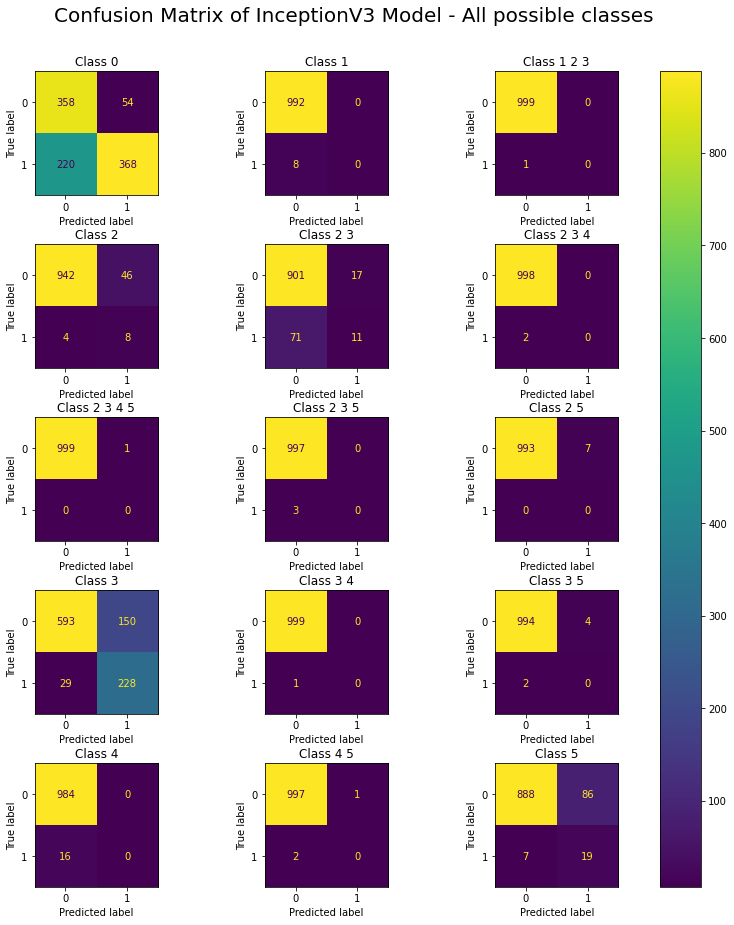

In [ ]:
confusion_matrix_plot(nrows=5, ncols=3, y_actual=y_actual, y_pred=y_pred
                      , num_classes=15, title="Confusion Matrix of InceptionV3 Model - All possible classes")

### Make confusion matrix V.2

In [ ]:
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0]])

##### make y_pred to one hot

In [ ]:
y_all

In [ ]:
df_y = pd.DataFrame(y_all, columns=['pred'])
df_y['pred'] = df_y['pred'].apply(lambda x:str(x))

df_dummies = df_y['pred'].str.get_dummies(sep=' ')
df_dummies.head()

0  2  3  4  5
0  0  0  1  0  0
1  1  0  0  0  0
2  0  0  0  0  1
3  1  0  0  0  0
4  0  0  1  0  0

In [ ]:
df_dummies.insert(loc=1, column='1', value=0)
df_dummies.head()

0  1  2  3  4  5
0  0  0  0  1  0  0
1  1  0  0  0  0  0
2  0  0  0  0  0  1
3  1  0  0  0  0  0
4  0  0  0  1  0  0

In [ ]:
y_pred_one_hot = df_dummies.values
y_pred_one_hot

array([[0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0]])

##### make confusion

In [ ]:
np.save("/content/drive/MyDrive/PiceFolder/Hack 5/utils/y_actual.npy", y)
np.save("/content/drive/MyDrive/PiceFolder/Hack 5/utils/y_pred.npy", y_pred_one_hot)

In [ ]:
list(y_pred_one_hot[:, 5]).count(1)

118

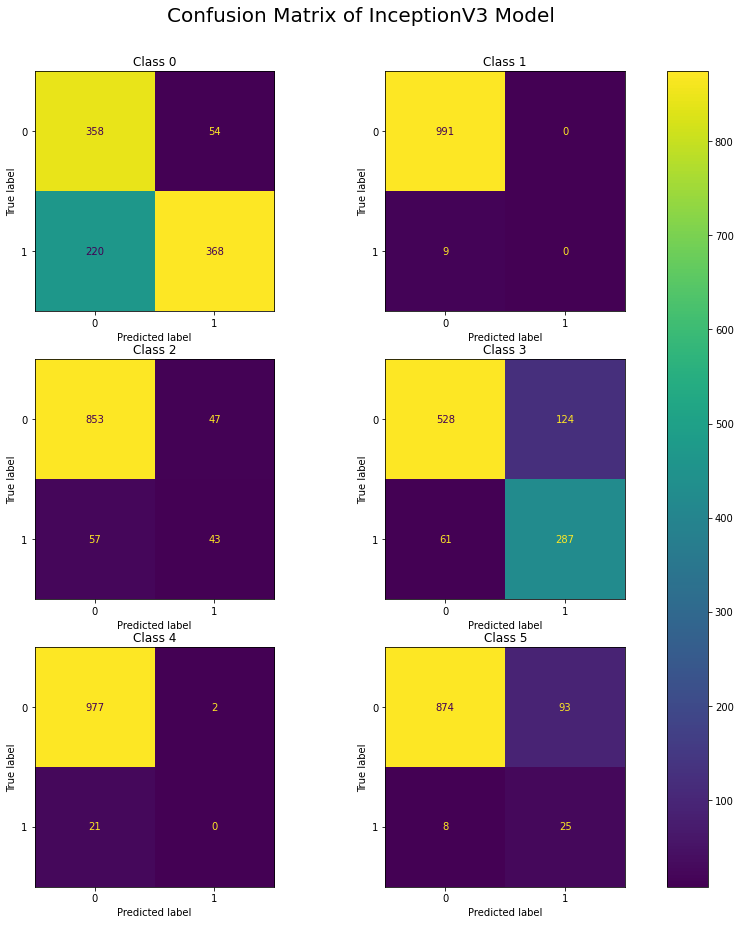

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.ravel()
for i in range(6):
  disp = ConfusionMatrixDisplay(confusion_matrix(y[:, i],
                                  y_pred_one_hot[:, i]),
                                  display_labels=[0, 1])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(f'Class {i}')
  # if i<4:
  #     disp.ax_.set_xlabel('')
  # if i%2!=0:
  #     disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()

fig.suptitle("Confusion Matrix of InceptionV3 Model", size=20, y=0.94)
plt.subplots_adjust(wspace=0.10, hspace=0.20)
fig.colorbar(disp.im_, ax=axes)
plt.savefig("/content/drive/MyDrive/PiceFolder/Hack 5/inceptionv3/InceptionV3_confusion_matrix.png")

plt.show()

### try test data

In [ ]:
def return_class(label): # label = [1,0,1,0,0,0]
  class_label = ""
  for i in range(len(a)):
    if label[i] == 1:
      class_label = class_label + " " + str(i)
  return class_label[1:]

def plot_pic(img):
  plt.imshow(img)
  plt.axis('off')
  plt.plot()

def prediction(img):
  print("Probability of all classes are {}".format(loaded_model.predict(img.reshape(1,299,299,3))))
  print("The max prob is class {}".format(np.argmax(loaded_model.predict(img.reshape(1,299,299,3)))))
  answer = condition_label(loaded_model.predict(img.reshape(1,299,299,3)))
  return answer
  # plt.title(return_class(label))

def condition_label(predicted):
  check = []
  if predicted[0][2] >= 3e-1:
    check.append(2)
  if predicted[0][3] >= 3e-1:
    check.append(3)
  if predicted[0][4] >= 1e-1:
    check.append(4)
  if predicted[0][5] >= 1e-4:
    check.append(5)

  print("check = {}".format(check))

  if check is not None:
    ans = ""
    for i in check:
      ans = ans + str(i) + " "
    ans = ans[:-1]
  if ans == "":
    ans = "0"
  print(ans)
  
  return ans

- class 0 : > 5*10-1 if then gaurantee class 0
- class 1 : > 1*10-20
- class 2 : > 3*10-1 but 2 must > class 0
- class 3 : > 3*10-1 but 3 must > class 0
- class 4 : > 1*10-5
- class 5 : > 1*10-5

##### get the test data

In [ ]:
file_name = os.listdir("/content/house-grade-classification/test/")
df_test = pd.DataFrame(data=file_name, columns=['filename'])
df_test['path'] = df_test['filename'].apply(lambda x:"/content/house-grade-classification/test/" + x)
df_test

filename                                               path
0    17b3df85.jpg  /content/house-grade-classification/test/17b3d...
1    2fc8cc77.jpg  /content/house-grade-classification/test/2fc8c...
2    6f4c6ad6.jpg  /content/house-grade-classification/test/6f4c6...
3    c7b64e77.jpg  /content/house-grade-classification/test/c7b64...
4    34e65477.jpg  /content/house-grade-classification/test/34e65...
..            ...                                                ...
445  b079fd05.jpg  /content/house-grade-classification/test/b079f...
446  632726ba.jpg  /content/house-grade-classification/test/63272...
447  b90c1985.jpg  /content/house-grade-classification/test/b90c1...
448  3c4b55f8.jpg  /content/house-grade-classification/test/3c4b5...
449  b0c149d4.jpg  /content/house-grade-classification/test/b0c14...

[450 rows x 2 columns]

In [ ]:
from tqdm import tqdm

test_image = []

for i in tqdm(range(df_test.shape[0])):
    img = image.load_img(df_test.loc[i, 'path'], target_size=(299,299,3))
    img = image.img_to_array(img)
    img = img/255
    test_image.append(img)

test = np.array(test_image)

100%|██████████| 450/450 [00:05<00:00, 80.68it/s]


### Predict

In [ ]:
test_ans = []
for i in tqdm(test):  
  test_ans.append(prediction(i))

  0%|          | 0/450 [00:00<?, ?it/s]

Probability of all classes are [[5.1562777e-03 1.0288805e-25 1.0682808e-01 8.8749981e-01 5.1573961e-04
  9.1265235e-08]]
The max prob is class 3


  0%|          | 1/450 [00:00<05:47,  1.29it/s]

check = [3]
3
Probability of all classes are [[8.0647725e-01 1.7933024e-20 7.1872234e-02 9.5582075e-02 2.5298918e-02
  7.6948310e-04]]
The max prob is class 0


  0%|          | 2/450 [00:01<05:56,  1.26it/s]

check = [5]
5
Probability of all classes are [[8.6896038e-01 1.1274634e-25 7.7521048e-02 4.7128074e-02 6.3905600e-03
  1.4688372e-08]]
The max prob is class 0


  1%|          | 3/450 [00:02<05:44,  1.30it/s]

check = []
0
Probability of all classes are [[6.6682047e-01 8.5801442e-27 6.4548096e-03 3.1928068e-01 7.4439654e-03
  6.4562954e-08]]
The max prob is class 0


  1%|          | 4/450 [00:03<05:36,  1.32it/s]

check = [3]
3
Probability of all classes are [[7.9251186e-04 1.6089585e-23 5.7887509e-03 9.9332523e-01 9.3309813e-05
  6.5222949e-08]]
The max prob is class 3


  1%|          | 5/450 [00:03<05:36,  1.32it/s]

check = [3]
3
Probability of all classes are [[5.9543806e-01 6.4322714e-26 3.0149558e-01 1.0271654e-01 3.4864686e-04
  1.1297584e-06]]
The max prob is class 0


  1%|▏         | 6/450 [00:04<05:25,  1.36it/s]

check = [2]
2


  2%|▏         | 7/450 [00:05<05:05,  1.45it/s]

Probability of all classes are [[4.9944505e-01 1.8463708e-23 3.4059194e-01 1.5815812e-01 1.8043611e-03
  6.2760500e-07]]
The max prob is class 0
check = [2]
2
Probability of all classes are [[8.0556393e-01 1.3463303e-23 1.2965569e-01 6.2156346e-02 2.6234540e-03
  5.5194567e-07]]
The max prob is class 0


  2%|▏         | 8/450 [00:05<04:49,  1.53it/s]

check = []
0
Probability of all classes are [[3.3541417e-01 1.7936114e-23 4.7110823e-01 1.8544824e-01 8.0290511e-03
  3.0033917e-07]]


  2%|▏         | 9/450 [00:06<04:39,  1.58it/s]

The max prob is class 2
check = [2]
2
Probability of all classes are [[1.85455885e-02 4.48635337e-30 5.07407248e-01 4.73938078e-01
  1.09151115e-04 1.48872425e-11]]
The max prob is class 2


  2%|▏         | 10/450 [00:06<04:32,  1.62it/s]

check = [2, 3]
2 3
Probability of all classes are [[8.6435336e-01 7.5036092e-26 2.5375482e-02 9.9544495e-02 1.0713222e-02
  1.3441216e-05]]


  2%|▏         | 11/450 [00:07<04:27,  1.64it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[4.7949019e-01 3.6407930e-22 1.1629121e-01 3.4612352e-01 5.3965028e-02
  4.1299607e-03]]
The max prob is class 0


  3%|▎         | 12/450 [00:08<04:23,  1.66it/s]

check = [3, 5]
3 5
Probability of all classes are [[5.5494314e-01 8.6333758e-24 2.9751143e-01 1.4047441e-01 7.0710690e-03
  1.1980175e-08]]


  3%|▎         | 13/450 [00:08<04:20,  1.68it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[7.2104514e-01 1.0222624e-22 2.1176602e-01 4.9922641e-02 1.7265445e-02
  8.0996705e-07]]
The max prob is class 0


  3%|▎         | 14/450 [00:09<04:17,  1.69it/s]

check = []
0
Probability of all classes are [[4.5122972e-01 7.6402939e-25 3.2427543e-01 2.2368871e-01 8.0610754e-04
  4.9192877e-08]]


  3%|▎         | 15/450 [00:09<04:16,  1.70it/s]

The max prob is class 0
check = [2]
2
Probability of all classes are [[9.0519238e-01 4.0368312e-22 7.5923535e-03 8.5956246e-02 1.2529563e-03
  6.0489651e-06]]
The max prob is class 0


  4%|▎         | 16/450 [00:10<04:18,  1.68it/s]

check = []
0
Probability of all classes are [[3.5718524e-01 1.9764177e-19 4.6059862e-01 1.7735995e-01 4.8335497e-03
  2.2693293e-05]]


  4%|▍         | 17/450 [00:10<04:16,  1.69it/s]

The max prob is class 2
check = [2]
2
Probability of all classes are [[8.8526750e-01 9.4141548e-20 3.6630902e-02 7.4218094e-02 3.8578066e-03
  2.5639169e-05]]
The max prob is class 0


  4%|▍         | 18/450 [00:11<04:16,  1.68it/s]

check = []
0
Probability of all classes are [[8.3545238e-01 4.0422805e-16 2.3714429e-02 9.0895601e-02 4.8846316e-02
  1.0912102e-03]]
The max prob is class 0


  4%|▍         | 19/450 [00:12<04:16,  1.68it/s]

check = [5]
5
Probability of all classes are [[7.3926675e-01 3.4636225e-21 1.6846296e-01 8.7685965e-02 4.5815650e-03
  2.7243905e-06]]


  4%|▍         | 20/450 [00:12<04:15,  1.68it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[8.9755869e-01 1.6972104e-21 4.3531917e-02 4.5263268e-02 1.3567292e-02
  7.8862999e-05]]
The max prob is class 0


  5%|▍         | 21/450 [00:13<04:13,  1.69it/s]

check = []
0
Probability of all classes are [[8.1376272e-01 6.8410887e-20 6.5983236e-02 1.1474181e-01 5.3891945e-03
  1.2298481e-04]]
The max prob is class 0


  5%|▍         | 22/450 [00:13<04:14,  1.68it/s]

check = [5]
5
Probability of all classes are [[6.6890979e-01 2.2468632e-19 2.9158366e-01 3.4036681e-02 5.4206708e-03
  4.9292870e-05]]
The max prob is class 0


  5%|▌         | 23/450 [00:14<04:15,  1.67it/s]

check = []
0
Probability of all classes are [[6.4067036e-01 2.4703510e-25 3.4479629e-03 3.5178766e-01 4.0940577e-03
  4.6354305e-08]]
The max prob is class 0


  5%|▌         | 24/450 [00:15<04:16,  1.66it/s]

check = [3]
3
Probability of all classes are [[8.0992782e-01 2.2677684e-29 1.2605466e-01 6.2875658e-02 1.1418093e-03
  1.0515839e-09]]
The max prob is class 0


  6%|▌         | 25/450 [00:15<04:18,  1.65it/s]

check = []
0
Probability of all classes are [[4.5325682e-01 1.0694320e-17 3.0484134e-01 2.1498069e-01 2.6894854e-02
  2.6356414e-05]]
The max prob is class 0


  6%|▌         | 26/450 [00:16<04:17,  1.65it/s]

check = [2]
2
Probability of all classes are [[5.7325602e-01 3.1814822e-26 1.5321994e-01 2.3612693e-01 3.7397210e-02
  1.7753093e-08]]
The max prob is class 0


  6%|▌         | 27/450 [00:16<04:17,  1.64it/s]

check = []
0
Probability of all classes are [[7.03702152e-01 1.38319976e-24 1.02748364e-01 1.67286798e-01
  2.62626335e-02 1.80035642e-07]]
The max prob is class 0


  6%|▌         | 28/450 [00:17<04:16,  1.64it/s]

check = []
0
Probability of all classes are [[4.9225062e-01 3.6416536e-23 2.6420742e-01 2.3313378e-01 1.0400682e-02
  7.4002860e-06]]
The max prob is class 0


  6%|▋         | 29/450 [00:18<04:18,  1.63it/s]

check = []
0
Probability of all classes are [[6.5185380e-01 5.3090940e-20 1.4055228e-01 1.8760467e-01 1.9809626e-02
  1.7968862e-04]]
The max prob is class 0


  7%|▋         | 30/450 [00:18<04:16,  1.64it/s]

check = [5]
5
Probability of all classes are [[6.9255304e-01 2.2745792e-33 1.5694380e-01 1.4915477e-01 1.3484149e-03
  7.1272650e-09]]
The max prob is class 0


  7%|▋         | 31/450 [00:19<04:13,  1.65it/s]

check = []
0
Probability of all classes are [[2.5420592e-03 2.7400366e-26 1.0667252e-02 9.8661333e-01 1.7737287e-04
  8.4083256e-09]]


  7%|▋         | 32/450 [00:20<04:11,  1.66it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[4.2069784e-01 1.2202450e-22 1.5772228e-01 4.1314036e-01 8.4394589e-03
  1.2272426e-07]]
The max prob is class 0


  7%|▋         | 33/450 [00:20<04:08,  1.68it/s]

check = [3]
3
Probability of all classes are [[7.9279858e-01 1.7730293e-20 7.6231316e-02 1.2471372e-01 6.2555382e-03
  8.3773659e-07]]


  8%|▊         | 34/450 [00:21<04:06,  1.69it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[8.9935476e-01 4.1058263e-25 4.3749675e-02 5.4281443e-02 2.5615015e-03
  5.2594241e-05]]
The max prob is class 0


  8%|▊         | 35/450 [00:21<04:06,  1.69it/s]

check = []
0
Probability of all classes are [[8.2581973e-01 6.3083231e-23 1.0801733e-02 1.2937017e-01 3.2968458e-02
  1.0399695e-03]]


  8%|▊         | 36/450 [00:22<04:03,  1.70it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[5.9887332e-01 3.3804632e-20 1.2117196e-01 2.6278064e-01 1.7168015e-02
  6.0562838e-06]]
The max prob is class 0


  8%|▊         | 37/450 [00:22<04:03,  1.70it/s]

check = []
0
Probability of all classes are [[3.5975271e-01 1.5639635e-24 4.5062548e-01 1.8367642e-01 5.9411409e-03
  4.1869230e-06]]


  8%|▊         | 38/450 [00:23<04:02,  1.70it/s]

The max prob is class 2
check = [2]
2
Probability of all classes are [[2.2140923e-03 4.9796513e-31 1.7336704e-02 9.8042107e-01 2.8120783e-05
  1.6519021e-10]]
The max prob is class 3


  9%|▊         | 39/450 [00:24<04:02,  1.69it/s]

check = [3]
3
Probability of all classes are [[7.4399924e-01 1.1873093e-27 1.3041309e-01 1.2552425e-01 6.3374893e-05
  7.6320353e-11]]


  9%|▉         | 40/450 [00:24<04:00,  1.70it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[2.1141669e-02 1.2116353e-24 1.3358685e-01 8.4470725e-01 5.6381925e-04
  4.2902695e-07]]
The max prob is class 3


  9%|▉         | 41/450 [00:25<04:00,  1.70it/s]

check = [3]
3
Probability of all classes are [[1.8996321e-01 2.5345143e-23 6.9455975e-01 1.1421726e-01 1.2595798e-03
  1.8116822e-07]]
The max prob is class 2


  9%|▉         | 42/450 [00:25<04:02,  1.68it/s]

check = [2]
2
Probability of all classes are [[5.4590535e-01 3.3577933e-29 8.8823363e-02 3.6316338e-01 2.1078803e-03
  2.7070476e-10]]


 10%|▉         | 43/450 [00:26<04:02,  1.68it/s]

The max prob is class 0
check = [3]
3
Probability of all classes are [[6.32851183e-01 9.61036207e-26 9.44792107e-02 2.61982381e-01
  1.06847165e-02 2.39204996e-06]]


 10%|▉         | 44/450 [00:27<04:02,  1.67it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[8.5544097e-01 8.4828156e-25 7.4456185e-02 6.7594804e-02 2.4984728e-03
  9.5383411e-06]]
The max prob is class 0


 10%|█         | 45/450 [00:27<04:02,  1.67it/s]

check = []
0
Probability of all classes are [[5.8360791e-01 5.4449063e-25 1.9591416e-01 2.1305257e-01 7.4249767e-03
  3.8879813e-07]]
The max prob is class 0


 10%|█         | 46/450 [00:28<04:01,  1.67it/s]

check = []
0
Probability of all classes are [[8.7476307e-01 5.6198799e-20 4.0557675e-02 6.6085234e-02 1.7171104e-02
  1.4228877e-03]]
The max prob is class 0


 10%|█         | 47/450 [00:28<04:00,  1.68it/s]

check = [5]
5
Probability of all classes are [[8.3483696e-01 1.0717610e-20 4.2097688e-02 6.2980480e-02 4.5749631e-02
  1.4335260e-02]]


 11%|█         | 48/450 [00:29<03:57,  1.70it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[8.8831151e-01 4.6685729e-23 3.2254212e-02 6.8415664e-02 9.5023746e-03
  1.5162112e-03]]
The max prob is class 0


 11%|█         | 49/450 [00:30<03:57,  1.69it/s]

check = [5]
5


 11%|█         | 50/450 [00:30<03:56,  1.69it/s]

Probability of all classes are [[5.7353914e-01 2.2589908e-27 2.2122703e-01 1.9201776e-01 1.3198428e-02
  1.7644450e-05]]
The max prob is class 0
check = []
0
Probability of all classes are [[7.8165710e-01 5.8082180e-27 1.3900188e-01 7.1273081e-02 8.0554020e-03
  1.2594784e-05]]
The max prob is class 0


 11%|█▏        | 51/450 [00:31<03:55,  1.70it/s]

check = []
0
Probability of all classes are [[7.16234386e-01 7.39229327e-24 1.68703988e-01 1.10086426e-01
  4.97276383e-03 2.43965815e-06]]


 12%|█▏        | 52/450 [00:31<03:54,  1.70it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[9.0519768e-01 1.6283069e-23 1.0771233e-02 7.1596339e-02 1.2433228e-02
  1.5463222e-06]]
The max prob is class 0


 12%|█▏        | 53/450 [00:32<03:54,  1.69it/s]

check = []
0
Probability of all classes are [[8.8362759e-01 2.7954277e-19 7.7702180e-02 2.9395377e-02 9.2694471e-03
  5.4315160e-06]]


 12%|█▏        | 54/450 [00:33<03:52,  1.70it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[1.1613483e-02 2.3321036e-25 5.1656991e-01 4.7126180e-01 5.5462710e-04
  1.7052690e-07]]
The max prob is class 2


 12%|█▏        | 55/450 [00:33<03:52,  1.70it/s]

check = [2, 3]
2 3
Probability of all classes are [[7.4624872e-01 1.8016763e-20 2.0621080e-02 2.0846902e-01 2.3473954e-02
  1.1871762e-03]]


 12%|█▏        | 56/450 [00:34<03:51,  1.70it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[3.6368435e-03 3.5598007e-25 2.3608329e-02 9.7249144e-01 2.6329132e-04
  6.7873771e-08]]
The max prob is class 3


 13%|█▎        | 57/450 [00:34<03:49,  1.71it/s]

check = [3]
3
Probability of all classes are [[6.3581836e-01 3.4772169e-21 2.1862261e-01 1.3426268e-01 1.1295398e-02
  9.3466355e-07]]


 13%|█▎        | 58/450 [00:35<03:48,  1.72it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[3.2042563e-01 3.8892795e-25 1.4045904e-02 6.6295093e-01 2.5775395e-03
  2.1223975e-08]]
The max prob is class 3


 13%|█▎        | 59/450 [00:35<03:49,  1.70it/s]

check = [3]
3
Probability of all classes are [[9.5243710e-01 8.4016254e-19 2.2136865e-02 1.5868858e-02 7.1234647e-03
  2.4337166e-03]]


 13%|█▎        | 60/450 [00:36<03:48,  1.71it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[7.2664253e-02 6.8482317e-27 2.2904555e-01 6.9780141e-01 4.8871222e-04
  3.3765883e-08]]
The max prob is class 3


 14%|█▎        | 61/450 [00:37<03:48,  1.70it/s]

check = [3]
3
Probability of all classes are [[7.6473999e-01 2.9872334e-24 1.7611761e-01 4.7936756e-02 1.1205351e-02
  3.4518638e-07]]


 14%|█▍        | 62/450 [00:37<03:49,  1.69it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[5.3073955e-01 1.6004875e-19 1.3531876e-01 3.0984229e-01 2.3901224e-02
  1.9814941e-04]]
The max prob is class 0


 14%|█▍        | 63/450 [00:38<03:49,  1.68it/s]

check = [3, 5]
3 5
Probability of all classes are [[9.73550856e-01 1.22319220e-27 1.27356127e-02 1.20696165e-02
  1.63583946e-03 8.07583456e-06]]


 14%|█▍        | 64/450 [00:38<03:48,  1.69it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[6.3400584e-01 2.9961464e-23 1.1482152e-01 2.4689001e-01 4.2820787e-03
  4.8915462e-07]]
The max prob is class 0


 14%|█▍        | 65/450 [00:39<03:47,  1.69it/s]

check = []
0
Probability of all classes are [[4.3405282e-01 2.7120674e-26 4.1356984e-01 1.4521211e-01 7.1367398e-03
  2.8581158e-05]]


 15%|█▍        | 66/450 [00:40<03:45,  1.70it/s]

The max prob is class 0
check = [2]
2
Probability of all classes are [[1.9966255e-01 2.1187722e-26 2.3899397e-01 5.5357879e-01 7.7644717e-03
  2.7292842e-07]]
The max prob is class 3


 15%|█▍        | 67/450 [00:40<03:47,  1.69it/s]

check = [3]
3
Probability of all classes are [[7.4906796e-02 2.6975646e-27 7.8346347e-03 9.1545248e-01 1.8060587e-03
  9.5859187e-09]]
The max prob is class 3


 15%|█▌        | 68/450 [00:41<03:48,  1.67it/s]

check = [3]
3
Probability of all classes are [[7.1133351e-01 3.3862883e-23 4.1245673e-02 2.3061220e-01 1.6677987e-02
  1.3058867e-04]]
The max prob is class 0


 15%|█▌        | 69/450 [00:41<03:50,  1.65it/s]

check = [5]
5
Probability of all classes are [[8.4823525e-01 4.4747003e-22 8.2437649e-02 6.6455141e-02 2.8654584e-03
  6.4976030e-06]]


 16%|█▌        | 70/450 [00:42<03:48,  1.66it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[1.7326978e-01 5.3665414e-32 2.3527569e-01 5.7813406e-01 1.3320417e-02
  6.0351674e-10]]
The max prob is class 3


 16%|█▌        | 71/450 [00:43<03:46,  1.67it/s]

check = [3]
3
Probability of all classes are [[7.32564628e-01 6.67219059e-23 1.49448514e-01 1.10702015e-01
  7.26159057e-03 2.32720049e-05]]


 16%|█▌        | 72/450 [00:43<03:46,  1.67it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[2.7744818e-02 9.1947221e-25 2.3808940e-01 7.3399389e-01 1.7173721e-04
  6.5242453e-08]]
The max prob is class 3


 16%|█▌        | 73/450 [00:44<03:46,  1.66it/s]

check = [3]
3
Probability of all classes are [[1.1801076e-01 7.7136406e-30 3.7089440e-01 5.1067919e-01 4.1565241e-04
  2.2304457e-10]]


 16%|█▋        | 74/450 [00:44<03:45,  1.67it/s]

The max prob is class 3
check = [2, 3]
2 3
Probability of all classes are [[4.7374764e-01 1.8971811e-18 4.0519309e-01 1.1128187e-01 9.4556483e-03
  3.2180166e-04]]
The max prob is class 0


 17%|█▋        | 75/450 [00:45<03:45,  1.66it/s]

check = [2, 5]
2 5
Probability of all classes are [[2.4746710e-03 1.6942722e-28 1.0125634e-01 8.9612079e-01 1.4830744e-04
  4.9725970e-09]]


 17%|█▋        | 76/450 [00:46<03:44,  1.67it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[9.4404733e-01 1.3277826e-26 1.7477574e-02 3.0994026e-02 6.3214633e-03
  1.1596868e-03]]


 17%|█▋        | 77/450 [00:46<03:44,  1.66it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[7.0751661e-01 5.7411068e-24 2.2107279e-01 6.6026554e-02 5.3808959e-03
  3.0797576e-06]]
The max prob is class 0


 17%|█▋        | 78/450 [00:47<03:43,  1.66it/s]

check = []
0
Probability of all classes are [[1.0140119e-01 9.0775732e-28 9.2090465e-02 8.0599934e-01 5.0904101e-04
  1.0639006e-08]]
The max prob is class 3


 18%|█▊        | 79/450 [00:47<03:44,  1.65it/s]

check = [3]
3
Probability of all classes are [[5.3731114e-01 1.7844140e-22 2.3487715e-01 2.1954513e-01 8.2643889e-03
  2.2347624e-06]]
The max prob is class 0


 18%|█▊        | 80/450 [00:48<03:43,  1.66it/s]

check = []
0
Probability of all classes are [[7.3584902e-01 1.9577782e-26 2.0994537e-02 2.3330423e-01 9.8327370e-03
  1.9462645e-05]]
The max prob is class 0


 18%|█▊        | 81/450 [00:49<03:42,  1.66it/s]

check = []
0
Probability of all classes are [[9.4144088e-01 7.8803268e-24 3.9335154e-02 3.7834144e-03 8.7752519e-03
  6.6652740e-03]]


 18%|█▊        | 82/450 [00:49<03:42,  1.65it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[9.6984553e-01 2.4812555e-25 5.1367166e-03 1.9281924e-02 5.6457138e-03
  9.0070287e-05]]
The max prob is class 0


 18%|█▊        | 83/450 [00:50<03:40,  1.67it/s]

check = []
0


 19%|█▊        | 84/450 [00:50<03:38,  1.68it/s]

Probability of all classes are [[9.4286315e-02 1.8295554e-30 4.5885465e-01 4.4598758e-01 8.7142637e-04
  4.9010688e-11]]
The max prob is class 2
check = [2, 3]
2 3
Probability of all classes are [[5.6666291e-01 5.7787712e-30 1.6758704e-01 2.6568684e-01 6.3255247e-05
  7.2501803e-11]]
The max prob is class 0


 19%|█▉        | 85/450 [00:51<03:37,  1.68it/s]

check = []
0
Probability of all classes are [[2.0947540e-02 7.5579235e-26 5.4527950e-01 4.3351588e-01 2.5707961e-04
  1.4178900e-09]]


 19%|█▉        | 86/450 [00:52<03:34,  1.70it/s]

The max prob is class 2
check = [2, 3]
2 3
Probability of all classes are [[9.2247319e-01 1.5456245e-22 2.9694507e-02 3.3106405e-02 1.4043825e-02
  6.8200420e-04]]
The max prob is class 0


 19%|█▉        | 87/450 [00:52<03:32,  1.71it/s]

check = [5]
5
Probability of all classes are [[9.4277579e-01 2.6775836e-24 3.3451058e-02 2.1293955e-02 2.4386169e-03
  4.0533971e-05]]


 20%|█▉        | 88/450 [00:53<03:29,  1.73it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[6.9484407e-01 9.7290591e-26 2.1003544e-01 9.4278291e-02 8.4094296e-04
  1.2315563e-06]]
The max prob is class 0


 20%|█▉        | 89/450 [00:53<03:29,  1.72it/s]

check = []
0
Probability of all classes are [[3.6160168e-01 4.9966230e-27 3.6363786e-01 2.6545921e-01 9.3011949e-03
  1.7245192e-08]]


 20%|██        | 90/450 [00:54<03:29,  1.72it/s]

The max prob is class 2
check = [2]
2
Probability of all classes are [[3.9752167e-01 1.0771723e-15 2.6458034e-01 3.1615907e-01 2.0802105e-02
  9.3685510e-04]]
The max prob is class 0


 20%|██        | 91/450 [00:54<03:29,  1.71it/s]

check = [3, 5]
3 5
Probability of all classes are [[6.2382221e-01 5.0805111e-22 1.2576625e-01 2.2975765e-01 1.9927062e-02
  7.2686293e-04]]


 20%|██        | 92/450 [00:55<03:30,  1.70it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[7.5924262e-02 1.8650216e-27 1.9639904e-02 9.0021777e-01 4.2174612e-03
  6.2613026e-07]]
The max prob is class 3


 21%|██        | 93/450 [00:56<03:30,  1.70it/s]

check = [3]
3
Probability of all classes are [[8.74913990e-01 6.54648339e-23 8.83799493e-02 2.64249519e-02
  1.02801705e-02 1.00568843e-06]]


 21%|██        | 94/450 [00:56<03:30,  1.69it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[7.9184973e-01 8.5834901e-23 4.0282499e-02 1.6748685e-01 3.8085450e-04
  1.0563473e-07]]
The max prob is class 0


 21%|██        | 95/450 [00:57<03:28,  1.70it/s]

check = []
0
Probability of all classes are [[1.10279314e-01 1.78983603e-27 2.80852824e-01 6.07032776e-01
  1.83504517e-03 3.30884875e-10]]


 21%|██▏       | 96/450 [00:57<03:27,  1.71it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[4.5827869e-01 9.8578009e-18 1.5761505e-01 3.2059470e-01 6.3267700e-02
  2.4383100e-04]]
The max prob is class 0


 22%|██▏       | 97/450 [00:58<03:26,  1.71it/s]

check = [3, 5]
3 5
Probability of all classes are [[1.03010135e-02 9.00982445e-26 4.64315675e-02 9.43135560e-01
  1.31712630e-04 8.04782658e-08]]


 22%|██▏       | 98/450 [00:59<03:26,  1.70it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[3.3062096e-03 5.2595949e-27 2.0896456e-01 7.8766191e-01 6.7332076e-05
  1.8432542e-09]]
The max prob is class 3


 22%|██▏       | 99/450 [00:59<03:27,  1.69it/s]

check = [3]
3
Probability of all classes are [[8.2325560e-01 4.2874985e-23 4.4161424e-02 1.2364984e-01 8.9293262e-03
  3.8195712e-06]]


 22%|██▏       | 100/450 [01:00<03:25,  1.70it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[7.5273734e-01 9.6490825e-18 9.7272150e-02 1.4304996e-01 6.8588182e-03
  8.1774808e-05]]
The max prob is class 0


 22%|██▏       | 101/450 [01:00<03:24,  1.71it/s]

check = []
0
Probability of all classes are [[4.0330917e-01 2.5744193e-30 2.3634192e-01 3.5591909e-01 4.4260006e-03
  3.7984107e-06]]


 23%|██▎       | 102/450 [01:01<03:24,  1.70it/s]

The max prob is class 0
check = [3]
3
Probability of all classes are [[9.0322644e-01 1.0788214e-21 2.2435864e-02 2.7109107e-02 9.1103911e-03
  3.8118131e-02]]


 23%|██▎       | 103/450 [01:02<03:25,  1.69it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[1.7678723e-02 7.1603879e-34 2.0938268e-01 7.7246255e-01 4.7603581e-04
  8.0815082e-10]]
The max prob is class 3


 23%|██▎       | 104/450 [01:02<03:24,  1.69it/s]

check = [3]
3
Probability of all classes are [[4.4650856e-02 1.2928278e-25 5.3944752e-02 9.0034652e-01 1.0578068e-03
  2.2406519e-09]]
The max prob is class 3


 23%|██▎       | 105/450 [01:03<03:26,  1.67it/s]

check = [3]
3
Probability of all classes are [[9.0640366e-01 1.3120980e-26 1.7536674e-02 7.0571631e-02 5.4865903e-03
  1.5342712e-06]]
The max prob is class 0


 24%|██▎       | 106/450 [01:03<03:25,  1.67it/s]

check = []
0
Probability of all classes are [[9.0472192e-01 1.3240603e-19 3.1244520e-02 5.5712976e-02 3.0350864e-03
  5.2856123e-03]]


 24%|██▍       | 107/450 [01:04<03:22,  1.69it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[9.0591174e-01 2.4655256e-27 6.2550128e-02 3.1222656e-02 3.1087853e-04
  4.5657239e-06]]
The max prob is class 0


 24%|██▍       | 108/450 [01:05<03:21,  1.70it/s]

check = []
0


 24%|██▍       | 109/450 [01:05<03:19,  1.71it/s]

Probability of all classes are [[2.3213640e-01 2.4727167e-26 4.9347663e-01 2.6246765e-01 1.1876323e-02
  4.3084419e-05]]
The max prob is class 2
check = [2]
2
Probability of all classes are [[3.1535685e-02 1.4775837e-27 1.3458145e-01 8.3331501e-01 5.6787836e-04
  2.5913454e-09]]
The max prob is class 3


 24%|██▍       | 110/450 [01:06<03:18,  1.71it/s]

check = [3]
3
Probability of all classes are [[7.8049767e-01 2.6356618e-21 1.4151591e-01 4.8978284e-02 2.4587275e-02
  4.4209198e-03]]


 25%|██▍       | 111/450 [01:06<03:16,  1.72it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[9.42047477e-01 1.30400435e-20 1.66958086e-02 3.32421064e-02
  6.13492634e-03 1.87974598e-03]]


 25%|██▍       | 112/450 [01:07<03:18,  1.70it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[3.9213869e-01 1.2116602e-24 5.3117013e-01 7.1466088e-02 5.2246000e-03
  4.9105194e-07]]
The max prob is class 2


 25%|██▌       | 113/450 [01:07<03:18,  1.70it/s]

check = [2]
2
Probability of all classes are [[6.54540777e-01 2.89576954e-22 1.13008626e-01 2.11605236e-01
  2.05126815e-02 3.32651165e-04]]


 25%|██▌       | 114/450 [01:08<03:17,  1.70it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[7.1286911e-01 6.9289174e-25 1.9802910e-01 8.0628686e-02 8.4702373e-03
  2.8281254e-06]]
The max prob is class 0


 26%|██▌       | 115/450 [01:09<03:17,  1.70it/s]

check = []
0
Probability of all classes are [[5.1942861e-01 9.7222315e-27 3.3020923e-01 1.4332743e-01 7.0149377e-03
  1.9819307e-05]]


 26%|██▌       | 116/450 [01:09<03:15,  1.71it/s]

The max prob is class 0
check = [2]
2
Probability of all classes are [[6.34688795e-01 3.94236204e-23 2.31262237e-01 1.09963015e-01
  2.40673702e-02 1.85849567e-05]]


 26%|██▌       | 117/450 [01:10<03:18,  1.68it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[5.3181654e-01 1.4110451e-24 4.0661466e-01 5.6444429e-02 5.0737332e-03
  5.0685052e-05]]
The max prob is class 0


 26%|██▌       | 118/450 [01:10<03:18,  1.67it/s]

check = [2]
2
Probability of all classes are [[9.1442484e-01 3.9156380e-28 6.1113261e-02 2.3122475e-02 1.3394972e-03
  3.5654285e-08]]
The max prob is class 0


 26%|██▋       | 119/450 [01:11<03:21,  1.64it/s]

check = []
0
Probability of all classes are [[8.6932570e-01 1.9663731e-20 6.5258898e-02 3.1033779e-02 1.1377039e-02
  2.3004705e-02]]


 27%|██▋       | 120/450 [01:12<03:28,  1.59it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[9.1149300e-02 4.0514441e-24 1.7988333e-01 7.2393632e-01 5.0308411e-03
  1.3454826e-07]]
The max prob is class 3


 27%|██▋       | 121/450 [01:12<03:25,  1.60it/s]

check = [3]
3
Probability of all classes are [[6.1009750e-02 1.3084656e-26 1.3765553e-01 8.0021966e-01 1.1148439e-03
  2.0610787e-07]]
The max prob is class 3


 27%|██▋       | 122/450 [01:13<04:06,  1.33it/s]

check = [3]
3
Probability of all classes are [[1.5777500e-01 5.1204565e-28 5.0042957e-01 3.4014040e-01 1.6549933e-03
  4.8999851e-08]]


 27%|██▋       | 123/450 [01:14<03:51,  1.41it/s]

The max prob is class 2
check = [2, 3]
2 3
Probability of all classes are [[2.3244074e-02 1.2336938e-30 1.1496822e-02 9.6487868e-01 3.8041270e-04
  7.6496026e-10]]
The max prob is class 3


 28%|██▊       | 124/450 [01:15<03:45,  1.45it/s]

check = [3]
3
Probability of all classes are [[2.0132991e-03 2.5193870e-30 7.7205915e-03 9.9018806e-01 7.8035497e-05
  3.1095983e-11]]
The max prob is class 3


 28%|██▊       | 125/450 [01:15<03:39,  1.48it/s]

check = [3]
3
Probability of all classes are [[8.3514369e-01 7.2446305e-22 4.9446072e-02 1.0689186e-01 7.9051033e-03
  6.1323325e-04]]
The max prob is class 0


 28%|██▊       | 126/450 [01:16<03:32,  1.52it/s]

check = [5]
5
Probability of all classes are [[8.2624912e-01 5.5097838e-23 1.1925790e-01 4.4967797e-02 9.4309412e-03
  9.4223738e-05]]
The max prob is class 0


 28%|██▊       | 127/450 [01:17<03:27,  1.56it/s]

check = []
0
Probability of all classes are [[9.1231948e-01 1.0527662e-27 1.4764282e-02 6.1256044e-02 1.1591448e-02
  6.8765592e-05]]


 28%|██▊       | 128/450 [01:17<03:22,  1.59it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[9.9166118e-02 2.0084852e-21 2.6811749e-01 6.2947106e-01 3.2227072e-03
  2.2587705e-05]]
The max prob is class 3


 29%|██▊       | 129/450 [01:18<03:20,  1.60it/s]

check = [3]
3
Probability of all classes are [[7.2274083e-01 1.4211426e-24 2.2334265e-02 2.4907227e-01 5.8390568e-03
  1.3551925e-05]]
The max prob is class 0


 29%|██▉       | 130/450 [01:18<03:20,  1.60it/s]

check = []
0
Probability of all classes are [[7.8547508e-01 5.4602981e-20 3.2742582e-02 1.7638999e-01 5.3676371e-03
  2.4621539e-05]]
The max prob is class 0


 29%|██▉       | 131/450 [01:19<03:19,  1.60it/s]

check = []
0
Probability of all classes are [[5.5601619e-02 1.5195450e-28 3.4808296e-01 5.9573406e-01 5.8138935e-04
  2.5293472e-09]]


 29%|██▉       | 132/450 [01:20<03:18,  1.60it/s]

The max prob is class 3
check = [2, 3]
2 3
Probability of all classes are [[7.1149743e-01 1.0439343e-24 1.9752748e-01 7.0421994e-02 1.9018717e-02
  1.5343234e-03]]
The max prob is class 0


 30%|██▉       | 133/450 [01:20<03:14,  1.63it/s]

check = [5]
5
Probability of all classes are [[1.0507915e-01 1.2140852e-31 1.7074777e-01 7.2389436e-01 2.7872293e-04
  3.4610065e-10]]


 30%|██▉       | 134/450 [01:21<03:10,  1.66it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[3.9358754e-03 2.0285133e-25 8.7142564e-02 9.0871167e-01 2.0992204e-04
  2.7071943e-08]]
The max prob is class 3


 30%|███       | 135/450 [01:21<03:10,  1.66it/s]

check = [3]
3
Probability of all classes are [[9.5960909e-01 2.9948823e-22 2.2442844e-02 1.0981918e-02 6.2592183e-03
  7.0695247e-04]]


 30%|███       | 136/450 [01:22<03:08,  1.67it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[2.4891746e-01 3.9805951e-28 2.3906037e-01 5.0763762e-01 4.3844269e-03
  6.8205452e-08]]
The max prob is class 3


 30%|███       | 137/450 [01:23<03:05,  1.69it/s]

check = [3]
3
Probability of all classes are [[9.2782936e-04 4.0596504e-28 6.7053311e-02 9.3199176e-01 2.7155995e-05
  6.4443394e-12]]
The max prob is class 3


 31%|███       | 138/450 [01:23<03:05,  1.69it/s]

check = [3]
3
Probability of all classes are [[8.7704873e-01 4.6757469e-27 6.3015699e-02 5.8386806e-02 1.5487547e-03
  7.2738451e-09]]
The max prob is class 0


 31%|███       | 139/450 [01:24<03:07,  1.66it/s]

check = []
0
Probability of all classes are [[7.2658682e-01 2.2443008e-32 2.5023809e-02 2.4059941e-01 7.7899583e-03
  1.5069597e-09]]
The max prob is class 0


 31%|███       | 140/450 [01:24<03:06,  1.66it/s]

check = []
0
Probability of all classes are [[4.4466180e-01 5.2306882e-24 7.7289499e-02 4.7160977e-01 6.4308578e-03
  8.0782538e-06]]


 31%|███▏      | 141/450 [01:25<03:04,  1.68it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[5.8206462e-04 3.1952044e-23 4.1334793e-02 9.5804340e-01 3.9767452e-05
  1.3571727e-09]]
The max prob is class 3


 32%|███▏      | 142/450 [01:26<03:05,  1.66it/s]

check = [3]
3
Probability of all classes are [[7.43336439e-01 3.46967611e-24 1.42536551e-01 1.09727696e-01
  4.39636316e-03 2.99470548e-06]]


 32%|███▏      | 143/450 [01:26<03:05,  1.66it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[9.4559473e-01 4.7431125e-26 3.1568374e-02 1.9387083e-02 3.4497050e-03
  8.7853813e-08]]
The max prob is class 0


 32%|███▏      | 144/450 [01:27<03:05,  1.65it/s]

check = []
0
Probability of all classes are [[3.2505551e-01 3.0746364e-27 3.8142264e-01 2.9209012e-01 1.4318210e-03
  1.5784877e-08]]


 32%|███▏      | 145/450 [01:27<03:06,  1.64it/s]

The max prob is class 2
check = [2]
2
Probability of all classes are [[3.2187891e-01 7.9941665e-22 3.5822815e-01 2.7722305e-01 4.2575855e-02
  9.4054005e-05]]


 32%|███▏      | 146/450 [01:28<03:05,  1.64it/s]

The max prob is class 2
check = [2]
2
Probability of all classes are [[7.6129735e-01 8.1490311e-26 1.5971300e-01 6.7503028e-02 1.1486545e-02
  9.7127341e-08]]
The max prob is class 0


 33%|███▎      | 147/450 [01:29<03:02,  1.66it/s]

check = []
0
Probability of all classes are [[5.3615373e-01 1.9673987e-27 3.3156708e-01 1.3020860e-01 2.0697217e-03
  8.3057967e-07]]


 33%|███▎      | 148/450 [01:29<03:00,  1.67it/s]

The max prob is class 0
check = [2]
2
Probability of all classes are [[8.8109410e-01 1.0317514e-22 5.9351154e-02 4.8125673e-02 1.1337741e-02
  9.1263304e-05]]
The max prob is class 0


 33%|███▎      | 149/450 [01:30<02:58,  1.69it/s]

check = []
0
Probability of all classes are [[6.2639338e-01 1.1811617e-27 1.0433639e-01 2.6675773e-01 2.5125593e-03
  1.0306344e-08]]
The max prob is class 0


 33%|███▎      | 150/450 [01:30<02:56,  1.70it/s]

check = []
0
Probability of all classes are [[8.8184911e-01 6.7878197e-28 8.6836562e-02 2.6012663e-02 5.3015929e-03
  6.0832517e-09]]


 34%|███▎      | 151/450 [01:31<02:56,  1.69it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[9.0789759e-01 2.9818263e-22 1.2655100e-02 4.8275661e-02 3.0830430e-02
  3.4111826e-04]]
The max prob is class 0


 34%|███▍      | 152/450 [01:32<02:55,  1.69it/s]

check = [5]
5
Probability of all classes are [[3.8790828e-01 5.5290042e-22 3.6216661e-01 1.9926414e-01 5.0078351e-02
  5.8269838e-04]]


 34%|███▍      | 153/450 [01:32<02:55,  1.69it/s]

The max prob is class 0
check = [2, 5]
2 5
Probability of all classes are [[1.1383861e-03 2.1323552e-28 6.7146845e-02 9.3169820e-01 1.6594897e-05
  5.1806154e-10]]
The max prob is class 3


 34%|███▍      | 154/450 [01:33<02:54,  1.69it/s]

check = [3]
3
Probability of all classes are [[6.7429537e-01 1.5325631e-32 1.8513139e-01 1.3880941e-01 1.7638541e-03
  2.4549868e-10]]


 34%|███▍      | 155/450 [01:33<02:56,  1.67it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[9.1340744e-01 4.2175346e-21 5.0515719e-02 3.2107785e-02 3.9323806e-03
  3.6831225e-05]]
The max prob is class 0


 35%|███▍      | 156/450 [01:34<02:56,  1.67it/s]

check = []
0
Probability of all classes are [[7.3664260e-01 5.4631995e-26 1.3374381e-01 1.2518141e-01 4.4318698e-03
  3.5655043e-07]]
The max prob is class 0


 35%|███▍      | 157/450 [01:35<02:55,  1.67it/s]

check = []
0
Probability of all classes are [[7.3561859e-01 3.5079822e-22 1.2365663e-01 1.2467213e-01 1.5096777e-02
  9.5590076e-04]]
The max prob is class 0


 35%|███▌      | 158/450 [01:35<02:54,  1.68it/s]

check = [5]
5
Probability of all classes are [[7.5201893e-01 2.0034878e-26 3.2976937e-02 2.1240169e-01 2.5747684e-03
  2.7588030e-05]]


 35%|███▌      | 159/450 [01:36<02:52,  1.69it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[7.0575100e-01 7.6398308e-19 1.1900579e-01 1.2889603e-01 2.6175631e-02
  2.0171482e-02]]
The max prob is class 0


 36%|███▌      | 160/450 [01:36<02:51,  1.69it/s]

check = [5]
5
Probability of all classes are [[1.3744989e-01 2.8677285e-25 7.6616621e-01 9.3549795e-02 2.8339394e-03
  2.2195316e-07]]


 36%|███▌      | 161/450 [01:37<02:49,  1.70it/s]

The max prob is class 2
check = [2]
2
Probability of all classes are [[9.5128909e-02 7.8453714e-28 5.5652517e-01 3.4450141e-01 3.8443892e-03
  1.2389989e-07]]
The max prob is class 2


 36%|███▌      | 162/450 [01:37<02:50,  1.69it/s]

check = [2, 3]
2 3
Probability of all classes are [[1.0070316e-03 3.2156927e-29 8.3091613e-03 9.9065316e-01 3.0655712e-05
  1.3436514e-10]]


 36%|███▌      | 163/450 [01:38<02:49,  1.69it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[9.7042602e-01 1.5915834e-18 1.5571963e-02 7.0691351e-03 6.7297886e-03
  2.0314760e-04]]
The max prob is class 0


 36%|███▋      | 164/450 [01:39<02:48,  1.70it/s]

check = [5]
5
Probability of all classes are [[7.46001065e-01 3.19630020e-20 1.15603246e-01 1.06693886e-01
  3.16775553e-02 2.42149945e-05]]


 37%|███▋      | 165/450 [01:39<02:50,  1.67it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[2.3538516e-01 8.7829288e-24 5.7706314e-01 1.8018991e-01 7.3614530e-03
  3.2682638e-07]]
The max prob is class 2


 37%|███▋      | 166/450 [01:40<02:49,  1.68it/s]

check = [2]
2
Probability of all classes are [[8.7216276e-01 4.6877592e-19 7.9758890e-02 3.4497038e-02 1.3521608e-02
  5.9782840e-05]]


 37%|███▋      | 167/450 [01:40<02:48,  1.68it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[2.0945521e-01 3.9661365e-27 7.0064567e-02 7.1230698e-01 8.1731761e-03
  1.8655365e-08]]
The max prob is class 3


 37%|███▋      | 168/450 [01:41<02:53,  1.62it/s]

check = [3]
3
Probability of all classes are [[7.8883755e-01 7.4946304e-21 7.1429066e-02 1.3201317e-01 7.7132210e-03
  7.0477281e-06]]
The max prob is class 0


 38%|███▊      | 169/450 [01:42<02:51,  1.64it/s]

check = []
0
Probability of all classes are [[9.1309428e-01 4.7021108e-22 2.1586932e-02 6.2246926e-02 2.9770951e-03
  9.4820629e-05]]


 38%|███▊      | 170/450 [01:42<02:48,  1.66it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[1.5375458e-01 1.8088442e-27 3.3999702e-01 5.0562102e-01 6.2736351e-04
  9.2231609e-09]]
The max prob is class 3


 38%|███▊      | 171/450 [01:43<02:46,  1.67it/s]

check = [2, 3]
2 3
Probability of all classes are [[7.3925942e-01 2.6361023e-23 4.9349260e-02 1.9483496e-01 1.6524889e-02
  3.1436652e-05]]
The max prob is class 0


 38%|███▊      | 172/450 [01:43<02:45,  1.68it/s]

check = []
0
Probability of all classes are [[9.8522979e-01 9.9038570e-29 2.7582019e-03 7.7639488e-03 4.2480654e-03
  1.1448717e-08]]


 38%|███▊      | 173/450 [01:44<02:44,  1.69it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[1.21648066e-01 3.15740191e-26 1.09124519e-01 7.68933296e-01
  2.94191006e-04 3.68013424e-08]]
The max prob is class 3


 39%|███▊      | 174/450 [01:45<02:44,  1.67it/s]

check = [3]
3
Probability of all classes are [[5.6084049e-01 3.9378715e-23 2.6879874e-01 1.6901265e-01 1.3471664e-03
  1.0003754e-06]]


 39%|███▉      | 175/450 [01:45<02:45,  1.66it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[6.1887085e-01 2.9099231e-22 2.1348479e-01 1.5943469e-01 8.1568342e-03
  5.2887088e-05]]
The max prob is class 0


 39%|███▉      | 176/450 [01:46<02:45,  1.66it/s]

check = []
0
Probability of all classes are [[9.1486412e-01 3.8268740e-27 6.5556429e-02 1.9138655e-02 4.4058487e-04
  1.5750497e-07]]


 39%|███▉      | 177/450 [01:46<02:45,  1.65it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[2.9317978e-01 4.1206048e-26 3.9838809e-01 3.0642575e-01 2.0062935e-03
  7.4478130e-08]]
The max prob is class 2


 40%|███▉      | 178/450 [01:47<02:46,  1.64it/s]

check = [2, 3]
2 3
Probability of all classes are [[4.4575638e-01 4.4981242e-27 3.2920215e-01 2.1325058e-01 1.1790879e-02
  1.2236480e-07]]
The max prob is class 0


 40%|███▉      | 179/450 [01:48<02:48,  1.60it/s]

check = [2]
2
Probability of all classes are [[6.1496437e-01 7.1581192e-28 2.3401327e-01 1.4905688e-01 1.9654373e-03
  1.8035614e-08]]
The max prob is class 0


 40%|████      | 180/450 [01:48<02:47,  1.62it/s]

check = []
0
Probability of all classes are [[4.3849021e-01 3.3271309e-21 4.1889578e-01 1.3912715e-01 3.4863830e-03
  5.2922127e-07]]
The max prob is class 0


 40%|████      | 181/450 [01:49<02:45,  1.62it/s]

check = [2]
2
Probability of all classes are [[9.1211694e-01 4.4570370e-23 2.3081016e-02 6.1896309e-02 2.9027141e-03
  2.9931496e-06]]
The max prob is class 0


 40%|████      | 182/450 [01:50<02:45,  1.62it/s]

check = []
0
Probability of all classes are [[6.08538091e-03 1.14980714e-20 3.91356684e-02 9.53742504e-01
  1.03481417e-03 1.58820910e-06]]


 41%|████      | 183/450 [01:50<02:41,  1.66it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[3.6113033e-01 2.4272578e-20 4.5006531e-01 1.8199828e-01 5.8771670e-03
  9.2888181e-04]]
The max prob is class 2


 41%|████      | 184/450 [01:51<02:39,  1.67it/s]

check = [2, 5]
2 5
Probability of all classes are [[1.97949033e-04 1.01181829e-29 1.46144703e-02 9.85183179e-01
  4.48956052e-06 1.05010174e-10]]


 41%|████      | 185/450 [01:51<02:41,  1.64it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[6.0507464e-01 5.4934369e-26 1.4909668e-01 2.4203734e-01 3.7913418e-03
  3.3893748e-08]]
The max prob is class 0


 41%|████▏     | 186/450 [01:52<02:38,  1.66it/s]

check = []
0
Probability of all classes are [[8.0095857e-01 2.6829974e-24 5.6186561e-03 1.8960677e-01 3.8159534e-03
  8.7876209e-08]]
The max prob is class 0


 42%|████▏     | 187/450 [01:53<02:38,  1.65it/s]

check = []
0
Probability of all classes are [[7.7153915e-01 3.9468336e-24 4.2085197e-02 1.7265876e-01 1.3649725e-02
  6.7205430e-05]]
The max prob is class 0


 42%|████▏     | 188/450 [01:53<02:37,  1.67it/s]

check = []
0
Probability of all classes are [[7.4366695e-01 7.8495604e-25 1.8347110e-01 6.1335206e-02 1.1525951e-02
  7.7832590e-07]]


 42%|████▏     | 189/450 [01:54<02:35,  1.68it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[8.9290911e-01 2.3434219e-21 4.0393125e-02 1.8884560e-02 1.8005481e-02
  2.9807666e-02]]
The max prob is class 0


 42%|████▏     | 190/450 [01:54<02:33,  1.69it/s]

check = [5]
5
Probability of all classes are [[9.1015476e-01 1.0014532e-22 3.4290459e-02 5.1797543e-02 3.5423364e-03
  2.1478217e-04]]
The max prob is class 0


 42%|████▏     | 191/450 [01:55<02:33,  1.68it/s]

check = [5]
5
Probability of all classes are [[5.1158236e-04 1.4285904e-27 2.2112389e-01 7.7832639e-01 3.8132737e-05
  1.3998973e-10]]
The max prob is class 3


 43%|████▎     | 192/450 [01:56<02:34,  1.67it/s]

check = [3]
3
Probability of all classes are [[9.2284828e-01 6.3464116e-24 3.1659186e-02 2.8921181e-02 1.6482815e-02
  8.8545021e-05]]


 43%|████▎     | 193/450 [01:56<02:32,  1.68it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[8.0467123e-01 4.9017988e-21 7.7685237e-02 1.1200808e-01 5.3172889e-03
  3.1816075e-04]]
The max prob is class 0


 43%|████▎     | 194/450 [01:57<02:32,  1.68it/s]

check = [5]
5
Probability of all classes are [[1.9162847e-01 2.1541674e-23 9.3958288e-02 7.1103072e-01 3.3588987e-03
  2.3540824e-05]]


 43%|████▎     | 195/450 [01:57<02:31,  1.68it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[1.6017228e-03 4.8036943e-24 2.4302748e-01 7.5509346e-01 2.7726949e-04
  6.7722830e-08]]
The max prob is class 3


 44%|████▎     | 196/450 [01:58<02:31,  1.68it/s]

check = [3]
3
Probability of all classes are [[7.7826965e-01 1.7684961e-31 3.9366488e-03 2.1648733e-01 1.3064357e-03
  5.3718618e-10]]
The max prob is class 0


 44%|████▍     | 197/450 [01:59<02:30,  1.68it/s]

check = []
0
Probability of all classes are [[9.0880024e-01 2.7660825e-26 1.5183455e-02 7.1933948e-02 4.0815859e-03
  6.0028901e-07]]


 44%|████▍     | 198/450 [01:59<02:30,  1.68it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[1.5901385e-02 3.9008642e-32 2.2639698e-01 7.5761527e-01 8.6302003e-05
  1.0937147e-10]]
The max prob is class 3


 44%|████▍     | 199/450 [02:00<02:28,  1.69it/s]

check = [3]
3
Probability of all classes are [[9.6037561e-01 2.9321759e-17 1.0344984e-02 1.2424474e-02 1.6831582e-02
  2.3470775e-05]]


 44%|████▍     | 200/450 [02:00<02:27,  1.70it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[8.3677953e-01 1.1637378e-27 6.3377969e-02 8.6913399e-02 1.2788296e-02
  1.4070170e-04]]
The max prob is class 0


 45%|████▍     | 201/450 [02:01<02:27,  1.69it/s]

check = [5]
5
Probability of all classes are [[4.0657818e-01 5.8988008e-23 3.6089051e-01 2.2911611e-01 3.4145720e-03
  7.0097616e-07]]
The max prob is class 0


 45%|████▍     | 202/450 [02:01<02:28,  1.67it/s]

check = [2]
2
Probability of all classes are [[6.9778109e-01 2.9578539e-21 1.2870677e-01 1.4683531e-01 2.6641324e-02
  3.5463880e-05]]
The max prob is class 0


 45%|████▌     | 203/450 [02:02<02:28,  1.66it/s]

check = []
0
Probability of all classes are [[1.4717515e-01 8.5611413e-31 1.3289677e-01 7.1948630e-01 4.4176803e-04
  1.3102809e-10]]


 45%|████▌     | 204/450 [02:03<02:28,  1.66it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[8.7829649e-01 3.4899451e-24 4.5773238e-02 7.2820246e-02 3.1099687e-03
  1.4669142e-07]]
The max prob is class 0


 46%|████▌     | 205/450 [02:03<02:27,  1.67it/s]

check = []
0
Probability of all classes are [[3.5086867e-01 1.6448196e-25 5.2274495e-01 1.1261078e-01 1.3775108e-02
  4.7206834e-07]]


 46%|████▌     | 206/450 [02:04<02:24,  1.69it/s]

The max prob is class 2
check = [2]
2
Probability of all classes are [[1.1361291e-03 6.2290087e-28 1.7313803e-02 9.8151922e-01 3.0911684e-05
  1.7163218e-09]]
The max prob is class 3


 46%|████▌     | 207/450 [02:04<02:22,  1.70it/s]

check = [3]
3
Probability of all classes are [[5.7730258e-01 2.5536769e-23 1.1002556e-01 2.8936613e-01 2.3291776e-02
  1.3885816e-05]]
The max prob is class 0


 46%|████▌     | 208/450 [02:05<02:22,  1.70it/s]

check = []
0
Probability of all classes are [[9.3584734e-01 6.9117792e-24 2.0507151e-02 3.6331061e-02 6.3605784e-03
  9.5387799e-04]]


 46%|████▋     | 209/450 [02:06<02:21,  1.71it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[3.1893775e-01 5.5537346e-25 4.9181440e-01 1.8756250e-01 1.6851118e-03
  2.0803549e-07]]
The max prob is class 2


 47%|████▋     | 210/450 [02:06<02:21,  1.69it/s]

check = [2]
2
Probability of all classes are [[8.0355394e-01 2.4315257e-25 8.9280106e-02 9.9295668e-02 7.7632098e-03
  1.0705447e-04]]


 47%|████▋     | 211/450 [02:07<02:20,  1.70it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[3.7546688e-01 4.8496746e-26 4.5140928e-01 1.5050341e-01 2.2617457e-02
  2.8727966e-06]]
The max prob is class 2


 47%|████▋     | 212/450 [02:07<02:20,  1.69it/s]

check = [2]
2
Probability of all classes are [[6.4983851e-01 4.7505068e-26 2.7993593e-01 6.8718590e-02 1.5065606e-03
  4.0510591e-07]]


 47%|████▋     | 213/450 [02:08<02:20,  1.68it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[9.3162555e-01 1.0092195e-23 1.7077904e-02 4.5954585e-02 5.1177111e-03
  2.2428087e-04]]
The max prob is class 0


 48%|████▊     | 214/450 [02:09<02:19,  1.69it/s]

check = [5]
5
Probability of all classes are [[7.3725456e-01 1.7904334e-22 7.6296166e-02 1.7947401e-01 6.9069150e-03
  6.8319110e-05]]


 48%|████▊     | 215/450 [02:09<02:19,  1.68it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[1.3079867e-01 1.0700098e-24 4.8715066e-02 8.1903917e-01 1.4344490e-03
  1.2633580e-05]]
The max prob is class 3


 48%|████▊     | 216/450 [02:10<02:25,  1.61it/s]

check = [3]
3
Probability of all classes are [[4.3424875e-03 6.4725791e-27 2.5395215e-02 9.7008431e-01 1.7797135e-04
  1.8283538e-09]]
The max prob is class 3


 48%|████▊     | 217/450 [02:11<02:25,  1.60it/s]

check = [3]
3
Probability of all classes are [[3.4620301e-05 6.9153763e-32 2.4722225e-03 9.9748755e-01 5.6254535e-06
  8.4713027e-12]]
The max prob is class 3


 48%|████▊     | 218/450 [02:11<02:33,  1.51it/s]

check = [3]
3
Probability of all classes are [[7.7735382e-01 4.4356233e-22 9.6492939e-02 1.2238866e-01 3.7216228e-03
  4.2877749e-05]]
The max prob is class 0


 49%|████▊     | 219/450 [02:12<02:37,  1.46it/s]

check = []
0
Probability of all classes are [[6.5910637e-01 8.4647980e-25 2.2424966e-01 6.5364018e-02 5.1273495e-02
  6.4077135e-06]]
The max prob is class 0


 49%|████▉     | 220/450 [02:13<02:36,  1.47it/s]

check = []
0
Probability of all classes are [[7.5853753e-01 3.8012464e-27 7.2732463e-02 1.6589794e-01 2.8301447e-03
  1.9194958e-06]]
The max prob is class 0


 49%|████▉     | 221/450 [02:13<02:34,  1.48it/s]

check = []
0
Probability of all classes are [[2.2969616e-03 5.8798205e-30 1.3162105e-01 8.6606520e-01 1.6849204e-05
  4.5258667e-12]]
The max prob is class 3


 49%|████▉     | 222/450 [02:14<02:34,  1.48it/s]

check = [3]
3
Probability of all classes are [[3.9097364e-04 5.2545561e-23 5.8473594e-02 9.4107014e-01 6.5250577e-05
  1.6032033e-08]]
The max prob is class 3


 50%|████▉     | 223/450 [02:15<02:33,  1.48it/s]

check = [3]
3
Probability of all classes are [[7.81100333e-01 6.13540953e-19 1.12041585e-01 6.85523823e-02
  1.43046044e-02 2.40010750e-02]]
The max prob is class 0


 50%|████▉     | 224/450 [02:15<02:30,  1.50it/s]

check = [5]
5
Probability of all classes are [[2.10401812e-03 1.56420705e-24 5.72401024e-02 9.40535188e-01
  1.20687655e-04 1.93662988e-08]]
The max prob is class 3


 50%|█████     | 225/450 [02:16<02:28,  1.51it/s]

check = [3]
3
Probability of all classes are [[5.0292566e-04 7.6606795e-29 1.1188507e-01 8.8759643e-01 1.5596612e-05
  2.3261974e-10]]
The max prob is class 3


 50%|█████     | 226/450 [02:17<02:25,  1.54it/s]

check = [3]
3
Probability of all classes are [[1.9521797e-01 7.7279725e-24 9.9088773e-02 7.0399451e-01 1.6953698e-03
  3.2368764e-06]]
The max prob is class 3


 50%|█████     | 227/450 [02:17<02:23,  1.55it/s]

check = [3]
3
Probability of all classes are [[6.6368753e-01 1.5098361e-23 1.8535981e-01 1.3712695e-01 1.3769352e-02
  5.6320299e-05]]
The max prob is class 0


 51%|█████     | 228/450 [02:18<02:22,  1.56it/s]

check = []
0
Probability of all classes are [[7.8059131e-01 1.0852860e-24 8.8030092e-02 1.0189256e-01 2.9464796e-02
  2.1179560e-05]]
The max prob is class 0


 51%|█████     | 229/450 [02:19<02:23,  1.55it/s]

check = []
0
Probability of all classes are [[7.0684463e-01 2.6277723e-28 1.9166656e-01 9.2390187e-02 9.0922033e-03
  6.3678167e-06]]
The max prob is class 0


 51%|█████     | 230/450 [02:19<02:21,  1.56it/s]

check = []
0
Probability of all classes are [[7.4241173e-01 1.4827912e-20 4.4902079e-02 1.9800846e-01 1.4651607e-02
  2.6229003e-05]]
The max prob is class 0


 51%|█████▏    | 231/450 [02:20<02:18,  1.58it/s]

check = []
0
Probability of all classes are [[5.9849542e-01 3.6561408e-25 5.5682339e-02 3.3593047e-01 9.8911040e-03
  6.8180850e-07]]
The max prob is class 0


 52%|█████▏    | 232/450 [02:20<02:17,  1.59it/s]

check = [3]
3
Probability of all classes are [[6.3055187e-01 1.7586636e-24 1.9967541e-01 1.6832839e-01 1.4442872e-03
  5.9918037e-08]]


 52%|█████▏    | 233/450 [02:21<02:13,  1.62it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[6.5794200e-01 9.6196440e-22 1.3562493e-01 1.8408068e-01 2.2323342e-02
  2.9112751e-05]]
The max prob is class 0


 52%|█████▏    | 234/450 [02:22<02:12,  1.63it/s]

check = []
0
Probability of all classes are [[6.5568775e-01 1.6292133e-22 1.8566402e-02 3.0391979e-01 2.1764696e-02
  6.1368068e-05]]


 52%|█████▏    | 235/450 [02:22<02:11,  1.63it/s]

The max prob is class 0
check = [3]
3
Probability of all classes are [[2.5191559e-03 4.8253260e-28 8.1540242e-02 9.1591167e-01 2.8894798e-05
  1.1010298e-09]]
The max prob is class 3


 52%|█████▏    | 236/450 [02:23<02:09,  1.65it/s]

check = [3]
3
Probability of all classes are [[8.9894503e-01 2.3928428e-22 7.4653127e-03 9.0359628e-02 3.2278856e-03
  2.1993014e-06]]


 53%|█████▎    | 237/450 [02:23<02:09,  1.65it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[6.3028687e-01 2.6487287e-25 1.0895403e-01 2.5980845e-01 9.5049420e-04
  2.3617345e-07]]
The max prob is class 0


 53%|█████▎    | 238/450 [02:24<02:08,  1.65it/s]

check = []
0
Probability of all classes are [[8.6786950e-01 1.0895916e-21 8.6130254e-02 3.8318168e-02 7.6664551e-03
  1.5640231e-05]]
The max prob is class 0


 53%|█████▎    | 239/450 [02:25<02:07,  1.65it/s]

check = []
0
Probability of all classes are [[2.1886670e-03 1.0078910e-18 1.1987703e-01 8.7770557e-01 2.2863728e-04
  5.9751677e-08]]
The max prob is class 3


 53%|█████▎    | 240/450 [02:25<02:08,  1.63it/s]

check = [3]
3
Probability of all classes are [[5.14997661e-01 3.60055161e-21 1.22180894e-01 3.09156448e-01
  5.36479689e-02 1.70204021e-05]]
The max prob is class 0


 54%|█████▎    | 241/450 [02:26<02:09,  1.61it/s]

check = [3]
3
Probability of all classes are [[1.9630124e-01 4.0893737e-27 5.4068345e-01 2.6235262e-01 6.6264771e-04
  4.7851870e-08]]
The max prob is class 2


 54%|█████▍    | 242/450 [02:27<02:11,  1.58it/s]

check = [2]
2
Probability of all classes are [[3.9799276e-01 1.4152309e-18 1.6169924e-01 3.7914202e-01 6.0699817e-02
  4.6614383e-04]]


 54%|█████▍    | 243/450 [02:27<02:09,  1.59it/s]

The max prob is class 0
check = [3, 5]
3 5
Probability of all classes are [[1.7409505e-03 6.4588901e-28 2.4429433e-02 9.7380733e-01 2.2293081e-05
  3.5453588e-11]]
The max prob is class 3


 54%|█████▍    | 244/450 [02:28<02:07,  1.61it/s]

check = [3]
3
Probability of all classes are [[9.1198939e-01 6.0695457e-26 5.2961171e-02 3.3878535e-02 1.1706362e-03
  2.5842380e-07]]


 54%|█████▍    | 245/450 [02:28<02:05,  1.63it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[7.0671421e-01 3.2224280e-25 1.9761769e-01 8.8801868e-02 6.8644024e-03
  1.7516263e-06]]


 55%|█████▍    | 246/450 [02:29<02:04,  1.64it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[5.3779012e-01 5.7520944e-21 1.9900456e-01 2.5887057e-01 4.3210294e-03
  1.3675047e-05]]
The max prob is class 0


 55%|█████▍    | 247/450 [02:30<02:03,  1.65it/s]

check = []
0
Probability of all classes are [[8.6875880e-01 3.3976752e-22 4.5784712e-02 8.1944533e-02 3.3180509e-03
  1.9399617e-04]]


 55%|█████▌    | 248/450 [02:30<02:01,  1.66it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[7.1373290e-01 5.1066211e-31 1.0812649e-01 1.7690472e-01 1.2358316e-03
  1.3300137e-09]]
The max prob is class 0


 55%|█████▌    | 249/450 [02:31<02:00,  1.66it/s]

check = []
0
Probability of all classes are [[6.3797820e-01 8.4194441e-21 2.0364888e-01 1.2229653e-01 3.6038429e-02
  3.7961297e-05]]
The max prob is class 0


 56%|█████▌    | 250/450 [02:31<02:00,  1.67it/s]

check = []
0
Probability of all classes are [[1.1474381e-03 5.2365913e-25 9.6464232e-02 9.0224856e-01 1.3983015e-04
  1.0340535e-09]]


 56%|█████▌    | 251/450 [02:32<01:58,  1.68it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[8.9499432e-01 5.4887452e-21 2.6703468e-02 7.2013877e-02 5.5768904e-03
  7.1149302e-04]]
The max prob is class 0


 56%|█████▌    | 252/450 [02:33<01:58,  1.67it/s]

check = [5]
5
Probability of all classes are [[5.4580724e-01 1.2108177e-19 3.0932570e-01 1.2387769e-01 2.0912854e-02
  7.6536497e-05]]


 56%|█████▌    | 253/450 [02:33<01:56,  1.69it/s]

The max prob is class 0
check = [2]
2
Probability of all classes are [[5.9149897e-01 1.3502936e-21 3.1940153e-01 7.3570810e-02 1.4705211e-02
  8.2340644e-04]]


 56%|█████▋    | 254/450 [02:34<01:56,  1.69it/s]

The max prob is class 0
check = [2, 5]
2 5
Probability of all classes are [[8.7825942e-01 2.1018365e-20 3.2895476e-02 6.7662120e-02 1.8628089e-02
  2.5549617e-03]]
The max prob is class 0


 57%|█████▋    | 255/450 [02:34<01:55,  1.68it/s]

check = [5]
5
Probability of all classes are [[4.9101263e-01 6.8889171e-26 3.0098571e-02 4.7457150e-01 4.3170969e-03
  2.0932532e-07]]


 57%|█████▋    | 256/450 [02:35<01:53,  1.70it/s]

The max prob is class 0
check = [3]
3
Probability of all classes are [[5.4022679e-03 3.3442064e-29 8.6594194e-02 9.0785652e-01 1.4693051e-04
  2.2576876e-09]]
The max prob is class 3


 57%|█████▋    | 257/450 [02:35<01:52,  1.71it/s]

check = [3]
3
Probability of all classes are [[7.8031880e-01 5.3556220e-25 3.5187945e-02 1.7795898e-01 6.5019680e-03
  3.2256121e-05]]
The max prob is class 0


 57%|█████▋    | 258/450 [02:36<01:52,  1.70it/s]

check = []
0
Probability of all classes are [[1.0160078e-02 6.4446503e-26 3.3925079e-02 9.5578545e-01 1.2932516e-04
  6.3337389e-09]]


 58%|█████▊    | 259/450 [02:37<01:51,  1.71it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[4.0170440e-01 2.5663867e-23 4.7474116e-01 1.0911166e-01 1.4439563e-02
  3.1786690e-06]]
The max prob is class 2


 58%|█████▊    | 260/450 [02:37<01:51,  1.71it/s]

check = [2]
2


 58%|█████▊    | 261/450 [02:38<01:50,  1.71it/s]

Probability of all classes are [[5.3180546e-01 2.8514117e-28 7.2324328e-02 3.6568269e-01 3.0186091e-02
  1.4227792e-06]]
The max prob is class 0
check = [3]
3
Probability of all classes are [[8.3884227e-01 1.6408896e-22 6.6085279e-02 9.0316840e-02 4.7551687e-03
  5.3132692e-07]]
The max prob is class 0


 58%|█████▊    | 262/450 [02:38<01:51,  1.68it/s]

check = []
0
Probability of all classes are [[1.7403323e-02 2.9830925e-22 7.1055442e-02 9.0983671e-01 1.7045427e-03
  1.0171936e-08]]
The max prob is class 3


 58%|█████▊    | 263/450 [02:39<01:51,  1.68it/s]

check = [3]
3
Probability of all classes are [[6.8091846e-01 8.9167953e-32 1.1046702e-01 2.0690928e-01 1.7052240e-03
  3.0367156e-10]]


 59%|█████▊    | 264/450 [02:40<01:49,  1.70it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[5.3928858e-01 1.3276714e-25 3.6007780e-01 9.7411774e-02 3.2216366e-03
  2.8375743e-07]]
The max prob is class 0


 59%|█████▉    | 265/450 [02:40<01:48,  1.70it/s]

check = [2]
2
Probability of all classes are [[9.9282712e-01 8.4481940e-30 2.0063815e-03 3.7801201e-03 1.3863911e-03
  1.6062136e-09]]


 59%|█████▉    | 266/450 [02:41<01:48,  1.70it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[3.2641488e-01 9.8184240e-30 5.2172266e-02 6.2101650e-01 3.9644827e-04
  1.4307465e-09]]


 59%|█████▉    | 267/450 [02:41<01:49,  1.68it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[1.7604208e-02 1.5410336e-26 1.6457516e-01 8.1731820e-01 5.0245028e-04
  1.4474926e-08]]
The max prob is class 3


 60%|█████▉    | 268/450 [02:42<01:49,  1.66it/s]

check = [3]
3
Probability of all classes are [[3.4965344e-03 3.8919928e-22 6.4367838e-02 9.3189627e-01 2.3915060e-04
  1.5022093e-07]]


 60%|█████▉    | 269/450 [02:43<01:48,  1.67it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[2.05597222e-01 2.22547464e-28 8.66207257e-02 7.04068780e-01
  3.71315121e-03 1.14134416e-07]]
The max prob is class 3


 60%|██████    | 270/450 [02:43<01:47,  1.67it/s]

check = [3]
3
Probability of all classes are [[6.4624810e-01 3.1149310e-26 2.8669305e-02 3.1905803e-01 6.0013491e-03
  2.3254925e-05]]


 60%|██████    | 271/450 [02:44<01:46,  1.68it/s]

The max prob is class 0
check = [3]
3
Probability of all classes are [[5.0217396e-01 1.8759241e-21 4.7752973e-02 4.4549927e-01 4.5718183e-03
  1.9823005e-06]]
The max prob is class 0


 60%|██████    | 272/450 [02:44<01:45,  1.68it/s]

check = [3]
3
Probability of all classes are [[5.2348326e-04 7.5716082e-29 2.5201291e-02 9.7426212e-01 1.3125959e-05
  2.1136859e-10]]


 61%|██████    | 273/450 [02:45<01:45,  1.67it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[2.6602420e-01 2.0059559e-26 4.5383774e-02 6.8573189e-01 2.8601454e-03
  6.6507560e-08]]
The max prob is class 3


 61%|██████    | 274/450 [02:46<01:45,  1.67it/s]

check = [3]
3
Probability of all classes are [[1.2131560e-01 5.3626035e-25 1.2031276e-01 7.5154108e-01 6.8266355e-03
  3.9453294e-06]]


 61%|██████    | 275/450 [02:46<01:46,  1.64it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[6.37766182e-01 6.34086333e-23 2.27055803e-01 1.15933374e-01
  1.91300008e-02 1.14650305e-04]]
The max prob is class 0


 61%|██████▏   | 276/450 [02:47<01:46,  1.64it/s]

check = [5]
5


 62%|██████▏   | 277/450 [02:47<01:45,  1.64it/s]

Probability of all classes are [[9.6806139e-01 4.3496474e-25 1.8188840e-02 9.9581489e-03 3.7847657e-03
  6.9606813e-06]]
The max prob is class 0
check = []
0
Probability of all classes are [[5.8655608e-01 2.4912384e-21 2.5593477e-01 1.4673792e-01 1.0759554e-02
  1.1623676e-05]]
The max prob is class 0


 62%|██████▏   | 278/450 [02:48<01:46,  1.61it/s]

check = []
0
Probability of all classes are [[3.9933255e-01 1.1948153e-20 1.1967473e-01 4.6137157e-01 1.9621206e-02
  3.0765651e-08]]
The max prob is class 3


 62%|██████▏   | 279/450 [02:49<01:45,  1.62it/s]

check = [3]
3
Probability of all classes are [[1.3224901e-01 2.6932165e-31 1.5577038e-01 7.1179652e-01 1.8413324e-04
  2.4252478e-11]]
The max prob is class 3


 62%|██████▏   | 280/450 [02:49<01:44,  1.63it/s]

check = [3]
3
Probability of all classes are [[5.3456557e-01 3.6286910e-22 3.0107450e-01 1.6137010e-01 2.9785957e-03
  1.1307619e-05]]
The max prob is class 0


 62%|██████▏   | 281/450 [02:50<01:43,  1.64it/s]

check = [2]
2
Probability of all classes are [[4.79816884e-01 3.17845136e-27 2.60553658e-01 2.44498745e-01
  1.51290605e-02 1.54937140e-06]]


 63%|██████▎   | 282/450 [02:50<01:41,  1.66it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[7.4994367e-01 7.7708169e-27 6.4764149e-03 2.3841241e-01 5.1672314e-03
  2.9216829e-07]]


 63%|██████▎   | 283/450 [02:51<01:40,  1.65it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[4.5161942e-01 1.0186355e-26 1.8583760e-02 5.2076346e-01 9.0238946e-03
  9.4285251e-06]]
The max prob is class 3


 63%|██████▎   | 284/450 [02:52<01:39,  1.67it/s]

check = [3]
3
Probability of all classes are [[5.5102015e-01 8.5160789e-26 1.5377631e-02 4.2923969e-01 4.3618847e-03
  6.8832719e-07]]
The max prob is class 0


 63%|██████▎   | 285/450 [02:52<01:40,  1.64it/s]

check = [3]
3
Probability of all classes are [[8.6004323e-01 9.4539123e-23 6.3778758e-02 6.7191325e-02 8.9174761e-03
  6.9284710e-05]]
The max prob is class 0


 64%|██████▎   | 286/450 [02:53<01:39,  1.65it/s]

check = []
0
Probability of all classes are [[9.0921545e-01 2.4450746e-25 2.7762620e-02 6.1956026e-02 1.0658822e-03
  5.6509586e-10]]


 64%|██████▍   | 287/450 [02:53<01:38,  1.66it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[1.1016161e-03 1.9382234e-28 2.6199773e-01 7.3685676e-01 4.3850174e-05
  2.0086955e-12]]
The max prob is class 3


 64%|██████▍   | 288/450 [02:54<01:38,  1.64it/s]

check = [3]
3
Probability of all classes are [[2.4126128e-03 8.1195177e-21 2.2805788e-01 7.6925290e-01 2.7668430e-04
  1.8853514e-08]]
The max prob is class 3


 64%|██████▍   | 289/450 [02:55<01:37,  1.65it/s]

check = [3]
3
Probability of all classes are [[7.5273490e-01 7.1475492e-24 8.4490605e-02 1.5761818e-01 5.1439037e-03
  1.2420936e-05]]


 64%|██████▍   | 290/450 [02:55<01:35,  1.68it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[2.7834395e-01 1.0594572e-23 1.8856698e-01 5.1843041e-01 1.4654769e-02
  3.8785465e-06]]
The max prob is class 3


 65%|██████▍   | 291/450 [02:56<01:34,  1.68it/s]

check = [3]
3
Probability of all classes are [[9.7676772e-01 5.0726866e-30 2.5423199e-03 1.5977984e-02 4.6635014e-03
  4.8490099e-05]]
The max prob is class 0


 65%|██████▍   | 292/450 [02:56<01:34,  1.68it/s]

check = []
0
Probability of all classes are [[8.22801769e-01 1.34085485e-20 6.45964667e-02 9.98598337e-02
  6.96094614e-03 5.78105031e-03]]


 65%|██████▌   | 293/450 [02:57<01:33,  1.68it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[2.5302705e-01 7.3203263e-23 1.6869645e-01 5.7523894e-01 3.0374280e-03
  8.4090431e-08]]
The max prob is class 3


 65%|██████▌   | 294/450 [02:58<01:32,  1.68it/s]

check = [3]
3
Probability of all classes are [[4.8100379e-01 9.7144145e-27 4.1180393e-03 5.1327747e-01 1.6006837e-03
  5.7228373e-08]]
The max prob is class 3


 66%|██████▌   | 295/450 [02:58<01:32,  1.68it/s]

check = [3]
3
Probability of all classes are [[6.95103109e-01 1.10791804e-25 1.83734864e-01 1.06039450e-01
  1.51224332e-02 1.00073876e-07]]
The max prob is class 0


 66%|██████▌   | 296/450 [02:59<01:31,  1.68it/s]

check = []
0
Probability of all classes are [[5.7533216e-01 4.8407652e-27 2.4245395e-01 1.7701538e-01 5.1980442e-03
  5.0603734e-07]]
The max prob is class 0


 66%|██████▌   | 297/450 [02:59<01:30,  1.69it/s]

check = []
0
Probability of all classes are [[5.2968824e-01 4.8533706e-25 3.1112167e-01 1.3929518e-01 1.9891772e-02
  3.1073778e-06]]


 66%|██████▌   | 298/450 [03:00<01:30,  1.68it/s]

The max prob is class 0
check = [2]
2
Probability of all classes are [[1.18321858e-01 1.57154138e-21 1.05179854e-01 7.46358037e-01
  3.01400479e-02 2.98467285e-07]]
The max prob is class 3


 66%|██████▋   | 299/450 [03:01<01:29,  1.69it/s]

check = [3]
3
Probability of all classes are [[5.3487408e-01 1.9178095e-25 3.1279010e-01 1.2591666e-01 2.6367802e-02
  5.1344916e-05]]


 67%|██████▋   | 300/450 [03:01<01:28,  1.69it/s]

The max prob is class 0
check = [2]
2
Probability of all classes are [[8.3873779e-01 1.1461985e-25 2.2828648e-02 1.2842065e-01 9.9864984e-03
  2.6366644e-05]]
The max prob is class 0


 67%|██████▋   | 301/450 [03:02<01:28,  1.68it/s]

check = []
0
Probability of all classes are [[6.7920587e-03 6.6774996e-27 2.4859486e-02 9.6811301e-01 2.3538082e-04
  4.5749626e-08]]


 67%|██████▋   | 302/450 [03:02<01:27,  1.69it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[7.80881464e-01 6.64046954e-22 1.77848339e-01 4.01168093e-02
  1.03334268e-03 1.20093595e-04]]
The max prob is class 0


 67%|██████▋   | 303/450 [03:03<01:27,  1.67it/s]

check = [5]
5
Probability of all classes are [[4.6787381e-01 4.0992774e-24 3.9868215e-01 1.1992547e-01 1.3517000e-02
  1.5307625e-06]]
The max prob is class 0


 68%|██████▊   | 304/450 [03:04<01:27,  1.67it/s]

check = [2]
2
Probability of all classes are [[7.2095960e-01 4.5840559e-26 1.9124527e-01 8.5384130e-02 2.4109518e-03
  1.1090963e-07]]
The max prob is class 0


 68%|██████▊   | 305/450 [03:04<01:26,  1.67it/s]

check = []
0
Probability of all classes are [[9.4574994e-01 1.2075155e-24 1.8213246e-02 1.6893920e-02 1.1567155e-02
  7.5757457e-03]]


 68%|██████▊   | 306/450 [03:05<01:25,  1.69it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[6.6692108e-01 2.4515301e-30 1.7684598e-01 1.5404081e-01 2.1919163e-03
  2.4330839e-07]]
The max prob is class 0


 68%|██████▊   | 307/450 [03:05<01:24,  1.70it/s]

check = []
0
Probability of all classes are [[5.6499124e-01 9.7981682e-25 1.9628336e-01 2.1017040e-01 2.8544340e-02
  1.0737216e-05]]


 68%|██████▊   | 308/450 [03:06<01:23,  1.70it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[1.7976277e-01 7.8751012e-30 4.0307921e-01 4.1622984e-01 9.2811714e-04
  9.0447977e-10]]
The max prob is class 3


 69%|██████▊   | 309/450 [03:07<01:22,  1.71it/s]

check = [2, 3]
2 3
Probability of all classes are [[9.1984957e-01 2.2471476e-24 1.6959056e-02 5.9026964e-02 4.1015642e-03
  6.2813408e-05]]


 69%|██████▉   | 310/450 [03:07<01:21,  1.71it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[7.87559211e-01 1.24687505e-23 9.39744562e-02 1.09072179e-01
  9.39374883e-03 3.63206510e-07]]
The max prob is class 0


 69%|██████▉   | 311/450 [03:08<01:22,  1.69it/s]

check = []
0
Probability of all classes are [[3.2366997e-01 2.2582284e-23 4.5333824e-01 2.1671896e-01 6.2538120e-03
  1.8886669e-05]]


 69%|██████▉   | 312/450 [03:08<01:20,  1.71it/s]

The max prob is class 2
check = [2]
2
Probability of all classes are [[5.9259206e-01 2.5534940e-24 2.5403202e-01 1.4948364e-01 3.8910862e-03
  1.1409498e-06]]
The max prob is class 0


 70%|██████▉   | 313/450 [03:09<01:19,  1.72it/s]

check = []
0
Probability of all classes are [[8.1983900e-01 4.7244021e-23 8.9923918e-02 6.6760555e-02 2.3271242e-02
  2.0531921e-04]]


 70%|██████▉   | 314/450 [03:09<01:19,  1.71it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[9.4976366e-01 2.5951310e-25 2.0451954e-02 2.6697177e-02 1.3742157e-03
  1.7129552e-03]]
The max prob is class 0


 70%|███████   | 315/450 [03:10<01:20,  1.68it/s]

check = [5]
5
Probability of all classes are [[1.5762258e-02 3.1261584e-26 2.3636612e-01 7.4705499e-01 8.1661559e-04
  8.5548049e-09]]
The max prob is class 3


 70%|███████   | 316/450 [03:11<01:21,  1.64it/s]

check = [3]
3
Probability of all classes are [[2.0620477e-01 6.7103388e-25 5.6629980e-01 2.2451729e-01 2.9782052e-03
  2.3772992e-08]]
The max prob is class 2


 70%|███████   | 317/450 [03:11<01:23,  1.59it/s]

check = [2]
2
Probability of all classes are [[7.3843044e-01 3.1813982e-21 1.4982501e-02 2.2416632e-01 2.2396876e-02
  2.3861239e-05]]


 71%|███████   | 318/450 [03:12<01:22,  1.60it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[8.1684673e-01 1.2735822e-23 2.6465049e-02 1.4457856e-01 1.1979076e-02
  1.3058924e-04]]
The max prob is class 0


 71%|███████   | 319/450 [03:13<01:22,  1.60it/s]

check = [5]
5
Probability of all classes are [[8.3057261e-01 1.0258963e-26 3.7408412e-02 1.2988463e-01 2.1063203e-03
  2.8090659e-05]]


 71%|███████   | 320/450 [03:13<01:21,  1.59it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[3.9222372e-01 7.6283799e-26 2.8535020e-01 2.7566081e-01 4.6764456e-02
  7.2093991e-07]]
The max prob is class 0


 71%|███████▏  | 321/450 [03:14<01:22,  1.57it/s]

check = []
0
Probability of all classes are [[7.3793209e-01 2.2044582e-26 1.9771670e-01 6.2419709e-02 1.9291403e-03
  2.3866328e-06]]
The max prob is class 0


 72%|███████▏  | 322/450 [03:15<01:22,  1.56it/s]

check = []
0
Probability of all classes are [[9.4209522e-01 1.6636269e-23 2.0702101e-02 2.9285664e-02 7.4626496e-03
  4.5422540e-04]]
The max prob is class 0


 72%|███████▏  | 323/450 [03:15<01:21,  1.56it/s]

check = [5]
5
Probability of all classes are [[3.1133613e-01 3.7568253e-21 5.1065040e-01 1.7296766e-01 5.0053238e-03
  4.0566789e-05]]
The max prob is class 2


 72%|███████▏  | 324/450 [03:16<01:20,  1.57it/s]

check = [2]
2
Probability of all classes are [[7.8029072e-01 1.1028270e-24 9.3522929e-02 1.2305368e-01 3.1150000e-03
  1.7780294e-05]]
The max prob is class 0


 72%|███████▏  | 325/450 [03:16<01:19,  1.58it/s]

check = []
0
Probability of all classes are [[4.8041633e-01 1.5653388e-25 1.9608238e-01 2.9489401e-01 2.8563891e-02
  4.3450284e-05]]
The max prob is class 0


 72%|███████▏  | 326/450 [03:17<01:18,  1.59it/s]

check = []
0
Probability of all classes are [[6.9091982e-01 1.4914524e-22 1.6962750e-01 1.3403906e-01 5.4132068e-03
  5.3322816e-07]]


 73%|███████▎  | 327/450 [03:18<01:17,  1.58it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[8.6476606e-01 3.4369041e-23 8.2625180e-02 3.9852634e-02 1.2751669e-02
  4.4418730e-06]]
The max prob is class 0


 73%|███████▎  | 328/450 [03:18<01:16,  1.59it/s]

check = []
0
Probability of all classes are [[2.6019347e-01 3.2677380e-19 5.3567755e-01 1.9916877e-01 4.9295067e-03
  3.0746764e-05]]
The max prob is class 2


 73%|███████▎  | 329/450 [03:19<01:16,  1.59it/s]

check = [2]
2
Probability of all classes are [[3.1032959e-01 1.2687170e-23 5.6430578e-01 1.2465195e-01 7.1229052e-04
  4.6072267e-07]]
The max prob is class 2


 73%|███████▎  | 330/450 [03:20<01:14,  1.61it/s]

check = [2]
2
Probability of all classes are [[8.7218255e-01 8.2741790e-24 1.9942667e-02 8.9191549e-02 1.8662503e-02
  2.0697467e-05]]
The max prob is class 0
check = []
0

 74%|███████▎  | 331/450 [03:20<01:14,  1.60it/s]


Probability of all classes are [[8.8718027e-01 5.4939542e-25 2.2297051e-02 7.9767220e-02 1.0755201e-02
  2.2492198e-07]]


 74%|███████▍  | 332/450 [03:21<01:13,  1.62it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[8.6792022e-01 1.9013732e-25 4.2040523e-02 8.7866321e-02 2.1547757e-03
  1.8223955e-05]]
The max prob is class 0


 74%|███████▍  | 333/450 [03:21<01:11,  1.64it/s]

check = []
0
Probability of all classes are [[8.9379859e-01 9.7022693e-25 9.9814609e-03 8.9431994e-02 6.7794006e-03
  8.6745122e-06]]
The max prob is class 0


 74%|███████▍  | 334/450 [03:22<01:10,  1.64it/s]

check = []
0
Probability of all classes are [[7.5184488e-01 2.3104445e-23 1.3751202e-02 2.2761254e-01 6.7907390e-03
  6.6124994e-07]]


 74%|███████▍  | 335/450 [03:23<01:09,  1.65it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[6.0855544e-01 1.6043926e-25 3.0147752e-01 8.2459621e-02 7.5069130e-03
  5.0794984e-07]]
The max prob is class 0


 75%|███████▍  | 336/450 [03:23<01:09,  1.65it/s]

check = [2]
2
Probability of all classes are [[4.2577577e-01 1.4721774e-23 5.5655662e-02 5.1540494e-01 3.1550538e-03
  8.4855510e-06]]


 75%|███████▍  | 337/450 [03:24<01:09,  1.63it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[4.1698737e-04 3.5216102e-25 4.5390517e-02 9.5416379e-01 2.8765213e-05
  2.5917852e-09]]
The max prob is class 3


 75%|███████▌  | 338/450 [03:24<01:09,  1.62it/s]

check = [3]
3
Probability of all classes are [[7.7149343e-01 2.0261972e-22 7.9251982e-02 1.3683487e-01 1.2004028e-02
  4.1572392e-04]]
The max prob is class 0


 75%|███████▌  | 339/450 [03:25<01:08,  1.62it/s]

check = [5]
5
Probability of all classes are [[5.7230778e-03 1.1240382e-26 1.6184998e-01 8.3234167e-01 8.5354877e-05
  2.9455069e-09]]
The max prob is class 3


 76%|███████▌  | 340/450 [03:26<01:08,  1.60it/s]

check = [3]
3
Probability of all classes are [[4.2090833e-01 2.6249489e-24 2.4904530e-01 3.1705964e-01 1.2986358e-02
  3.0902245e-07]]


 76%|███████▌  | 341/450 [03:26<01:08,  1.60it/s]

The max prob is class 0
check = [3]
3
Probability of all classes are [[3.4320328e-01 5.0712413e-26 4.1794270e-01 2.2837162e-01 1.0479608e-02
  2.9326666e-06]]


 76%|███████▌  | 342/450 [03:27<01:06,  1.62it/s]

The max prob is class 2
check = [2]
2
Probability of all classes are [[7.6069152e-01 1.1870420e-23 4.0588127e-03 2.2972922e-01 5.5193692e-03
  1.1140736e-06]]
The max prob is class 0


 76%|███████▌  | 343/450 [03:28<01:05,  1.63it/s]

check = []
0
Probability of all classes are [[5.2310622e-01 4.1391423e-21 3.7790781e-01 9.4039984e-02 4.8646224e-03
  8.1393082e-05]]
The max prob is class 0


 76%|███████▋  | 344/450 [03:28<01:04,  1.63it/s]

check = [2]
2
Probability of all classes are [[7.5545269e-01 4.0895011e-24 7.3096440e-03 2.3277470e-01 4.4628447e-03
  1.2438504e-07]]
The max prob is class 0


 77%|███████▋  | 345/450 [03:29<01:04,  1.63it/s]

check = []
0
Probability of all classes are [[1.00706347e-04 1.17487774e-26 6.89670146e-02 9.30914462e-01
  1.77996117e-05 6.47981335e-10]]
The max prob is class 3


 77%|███████▋  | 346/450 [03:29<01:04,  1.62it/s]

check = [3]
3
Probability of all classes are [[2.3485421e-01 9.1215917e-31 2.8690758e-01 4.7604284e-01 2.1953851e-03
  1.2843827e-10]]


 77%|███████▋  | 347/450 [03:30<01:03,  1.61it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[2.0943746e-01 2.6933129e-26 5.9663182e-01 1.9235492e-01 1.5729388e-03
  2.9312318e-06]]
The max prob is class 2


 77%|███████▋  | 348/450 [03:31<01:03,  1.62it/s]

check = [2]
2
Probability of all classes are [[2.0536502e-01 2.5411815e-28 2.5539377e-01 5.2853101e-01 1.0709977e-02
  1.6199495e-07]]


 78%|███████▊  | 349/450 [03:31<01:02,  1.61it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[3.8013175e-02 7.4242508e-30 3.1411189e-01 6.4759141e-01 2.8347631e-04
  9.6411290e-10]]
The max prob is class 3


 78%|███████▊  | 350/450 [03:32<01:02,  1.60it/s]

check = [2, 3]
2 3
Probability of all classes are [[7.3681098e-01 1.4125920e-19 1.7112091e-01 7.6129355e-02 1.5409139e-02
  5.2962633e-04]]
The max prob is class 0


 78%|███████▊  | 351/450 [03:33<01:02,  1.57it/s]

check = [5]
5
Probability of all classes are [[9.5364690e-01 1.3439707e-22 1.4502475e-02 3.0742994e-02 1.1076458e-03
  1.3798149e-08]]
The max prob is class 0


 78%|███████▊  | 352/450 [03:33<01:02,  1.58it/s]

check = []
0
Probability of all classes are [[5.3830397e-01 8.7306506e-21 2.3237106e-01 2.2575851e-01 3.4628699e-03
  1.0357236e-04]]
The max prob is class 0


 78%|███████▊  | 353/450 [03:34<01:00,  1.62it/s]

check = [5]
5
Probability of all classes are [[7.3998600e-01 3.2276285e-19 1.1416134e-01 1.3717638e-01 8.1371367e-03
  5.3913193e-04]]
The max prob is class 0


 79%|███████▊  | 354/450 [03:34<00:59,  1.61it/s]

check = [5]
5


 79%|███████▉  | 355/450 [03:35<00:58,  1.64it/s]

Probability of all classes are [[8.8788033e-02 3.7168996e-24 1.3413172e-02 8.9683682e-01 9.6191076e-04
  5.9632477e-08]]
The max prob is class 3
check = [3]
3
Probability of all classes are [[1.5956850e-01 3.1408288e-19 5.8485419e-01 2.3222750e-01 2.3328666e-02
  2.1111307e-05]]
The max prob is class 2


 79%|███████▉  | 356/450 [03:36<00:56,  1.65it/s]

check = [2]
2
Probability of all classes are [[2.3853739e-01 1.2231871e-23 1.3878141e-01 6.1638200e-01 6.2992577e-03
  3.5049464e-08]]


 79%|███████▉  | 357/450 [03:36<00:55,  1.67it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[1.4214005e-04 1.9372160e-25 9.6625932e-02 9.0320951e-01 2.2378910e-05
  3.9873604e-11]]
The max prob is class 3


 80%|███████▉  | 358/450 [03:37<00:55,  1.67it/s]

check = [3]
3
Probability of all classes are [[9.7224313e-01 1.9929763e-20 1.2953534e-02 1.2908546e-02 1.8918222e-03
  3.0155054e-06]]


 80%|███████▉  | 359/450 [03:37<00:53,  1.69it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[4.4264752e-01 3.3836390e-27 2.9918140e-01 2.4909207e-01 9.0787178e-03
  3.5989899e-07]]
The max prob is class 0


 80%|████████  | 360/450 [03:38<00:53,  1.70it/s]

check = []
0
Probability of all classes are [[7.4807864e-01 2.5495063e-22 6.9404006e-02 1.6807412e-01 1.4402097e-02
  4.1230247e-05]]
The max prob is class 0


 80%|████████  | 361/450 [03:39<00:52,  1.69it/s]

check = []
0
Probability of all classes are [[2.7011451e-01 2.3423231e-24 3.7579590e-01 3.5122225e-01 2.8636386e-03
  3.6690626e-06]]


 80%|████████  | 362/450 [03:39<00:51,  1.71it/s]

The max prob is class 2
check = [2, 3]
2 3
Probability of all classes are [[5.4583447e-03 1.0478057e-32 1.7925648e-02 9.7655904e-01 5.6886500e-05
  1.2741386e-09]]
The max prob is class 3


 81%|████████  | 363/450 [03:40<00:50,  1.72it/s]

check = [3]
3
Probability of all classes are [[2.5541885e-03 1.6413612e-28 1.8404868e-01 8.1335062e-01 4.6417539e-05
  8.6898300e-10]]


 81%|████████  | 364/450 [03:40<00:50,  1.72it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[8.93778026e-01 1.07375116e-23 5.12989014e-02 4.62147593e-02
  8.64964258e-03 5.87451068e-05]]
The max prob is class 0


 81%|████████  | 365/450 [03:41<00:49,  1.71it/s]

check = []
0
Probability of all classes are [[9.1814089e-01 1.2532722e-20 5.4393247e-02 2.3241960e-02 4.2079473e-03
  1.5893873e-05]]
The max prob is class 0


 81%|████████▏ | 366/450 [03:41<00:49,  1.70it/s]

check = []
0
Probability of all classes are [[3.5712278e-01 2.9079535e-24 4.7670507e-01 1.6462424e-01 1.5475505e-03
  3.5206551e-07]]
The max prob is class 2


 82%|████████▏ | 367/450 [03:42<00:48,  1.71it/s]

check = [2]
2
Probability of all classes are [[2.4509694e-01 2.8027730e-29 1.6477139e-01 5.8982599e-01 3.0567404e-04
  2.3362250e-09]]


 82%|████████▏ | 368/450 [03:43<00:47,  1.72it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[5.1023787e-01 4.5878363e-27 2.9721975e-01 1.9010420e-01 2.4378756e-03
  3.0540912e-07]]
The max prob is class 0


 82%|████████▏ | 369/450 [03:43<00:47,  1.72it/s]

check = []
0
Probability of all classes are [[6.6234451e-03 4.4678000e-27 9.5927171e-02 8.9722532e-01 2.2402871e-04
  2.4706726e-09]]


 82%|████████▏ | 370/450 [03:44<00:46,  1.73it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[6.8746859e-01 2.7015261e-17 1.0069102e-01 4.9364280e-02 9.1306068e-02
  7.1170032e-02]]
The max prob is class 0


 82%|████████▏ | 371/450 [03:44<00:46,  1.70it/s]

check = [5]
5
Probability of all classes are [[9.1576982e-01 1.8000038e-27 5.0510541e-02 3.2627985e-02 1.0916708e-03
  3.7741451e-08]]


 83%|████████▎ | 372/450 [03:45<00:46,  1.69it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[6.9943696e-01 4.0285796e-21 2.6219133e-01 2.8853357e-02 9.3690297e-03
  1.4937081e-04]]
The max prob is class 0


 83%|████████▎ | 373/450 [03:46<00:45,  1.69it/s]

check = [5]
5
Probability of all classes are [[2.1771970e-01 2.5488683e-25 3.4723625e-01 4.3035266e-01 4.6911798e-03
  2.0685536e-07]]


 83%|████████▎ | 374/450 [03:46<00:44,  1.69it/s]

The max prob is class 3
check = [2, 3]
2 3
Probability of all classes are [[5.5290431e-02 6.4008393e-27 3.0984847e-02 9.1294622e-01 7.7853631e-04
  2.6148173e-08]]
The max prob is class 3


 83%|████████▎ | 375/450 [03:47<00:44,  1.68it/s]

check = [3]
3
Probability of all classes are [[1.8925096e-01 8.8934872e-26 6.3099480e-01 1.7763297e-01 2.1212068e-03
  1.9634451e-08]]


 84%|████████▎ | 376/450 [03:47<00:43,  1.69it/s]

The max prob is class 2
check = [2]
2
Probability of all classes are [[6.4236039e-01 2.9377259e-21 5.0184742e-02 2.9040173e-01 1.6928187e-02
  1.2495865e-04]]
The max prob is class 0


 84%|████████▍ | 377/450 [03:48<00:43,  1.67it/s]

check = [5]
5
Probability of all classes are [[7.1976525e-01 1.2423420e-25 1.4230227e-01 1.3225228e-01 5.6733820e-03
  6.8411764e-06]]


 84%|████████▍ | 378/450 [03:49<00:42,  1.67it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[9.0770388e-01 4.6425691e-26 1.8328412e-02 7.1715735e-02 2.2518963e-03
  6.9210081e-08]]
The max prob is class 0


 84%|████████▍ | 379/450 [03:49<00:41,  1.69it/s]

check = []
0
Probability of all classes are [[7.81454742e-01 7.34182166e-22 1.30351735e-02 1.80241808e-01
  2.48377770e-02 4.30499087e-04]]


 84%|████████▍ | 380/450 [03:50<00:41,  1.70it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[7.6865882e-01 1.9297199e-22 5.7075012e-02 1.4287484e-01 3.1101303e-02
  2.9005721e-04]]
The max prob is class 0


 85%|████████▍ | 381/450 [03:50<00:40,  1.71it/s]

check = [5]
5
Probability of all classes are [[2.5628927e-01 3.3851122e-26 2.6172724e-01 4.7624657e-01 5.7366095e-03
  3.2503618e-07]]
The max prob is class 3


 85%|████████▍ | 382/450 [03:51<00:39,  1.71it/s]

check = [3]
3
Probability of all classes are [[1.8548558e-02 3.4883315e-28 1.2232939e-02 9.6905810e-01 1.6039812e-04
  5.4452165e-10]]


 85%|████████▌ | 383/450 [03:51<00:39,  1.71it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[7.3484129e-01 2.1007453e-21 1.5814649e-01 9.4272330e-02 1.2086758e-02
  6.5316912e-04]]
The max prob is class 0


 85%|████████▌ | 384/450 [03:52<00:38,  1.70it/s]

check = [5]
5
Probability of all classes are [[4.4389084e-01 7.6117993e-24 3.5422477e-01 1.8011601e-01 2.1768020e-02
  3.7288950e-07]]


 86%|████████▌ | 385/450 [03:53<00:38,  1.70it/s]

The max prob is class 0
check = [2]
2
Probability of all classes are [[4.2676303e-01 1.6307405e-23 2.0348677e-02 5.4737288e-01 5.3410945e-03
  1.7428650e-04]]
The max prob is class 3


 86%|████████▌ | 386/450 [03:53<00:37,  1.70it/s]

check = [3, 5]
3 5
Probability of all classes are [[3.6862192e-01 1.7421406e-27 3.0855963e-01 3.2073376e-01 2.0833772e-03
  1.3469913e-06]]
The max prob is class 0


 86%|████████▌ | 387/450 [03:54<00:37,  1.68it/s]

check = [2, 3]
2 3
Probability of all classes are [[5.6013513e-01 2.3667608e-18 2.1139994e-01 1.6923337e-01 4.4155244e-02
  1.5076342e-02]]


 86%|████████▌ | 388/450 [03:54<00:36,  1.69it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[1.8584514e-02 3.9222372e-30 2.6598347e-02 9.5460099e-01 2.1615210e-04
  4.2771768e-09]]
The max prob is class 3


 86%|████████▋ | 389/450 [03:55<00:36,  1.69it/s]

check = [3]
3
Probability of all classes are [[8.8161873e-03 3.2816740e-26 1.8799284e-01 8.0306065e-01 1.3028769e-04
  2.1427406e-08]]


 87%|████████▋ | 390/450 [03:56<00:35,  1.69it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[7.8116488e-01 6.4663288e-25 7.2217524e-02 1.3966247e-01 6.9550830e-03
  3.4090924e-08]]
The max prob is class 0


 87%|████████▋ | 391/450 [03:56<00:35,  1.68it/s]

check = []
0
Probability of all classes are [[9.1471422e-01 4.7243049e-24 5.2741427e-02 3.1183481e-02 1.3376331e-03
  2.3191513e-05]]


 87%|████████▋ | 392/450 [03:57<00:34,  1.68it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[7.1732050e-01 2.7893209e-18 1.3784207e-01 1.0729257e-01 3.7163150e-02
  3.8172628e-04]]
The max prob is class 0


 87%|████████▋ | 393/450 [03:57<00:33,  1.68it/s]

check = [5]
5
Probability of all classes are [[8.7643843e-03 1.2994772e-27 4.2367425e-02 9.4851756e-01 3.5053387e-04
  1.4161692e-07]]
The max prob is class 3


 88%|████████▊ | 394/450 [03:58<00:33,  1.67it/s]

check = [3]
3
Probability of all classes are [[9.5996189e-01 4.0897516e-20 2.1029152e-02 8.4892893e-03 9.3100118e-03
  1.2097091e-03]]
The max prob is class 0


 88%|████████▊ | 395/450 [03:59<00:33,  1.65it/s]

check = [5]
5
Probability of all classes are [[9.4257867e-01 3.1459100e-21 8.2909111e-03 3.0823279e-02 1.8306831e-02
  3.6509329e-07]]
The max prob is class 0


 88%|████████▊ | 396/450 [03:59<00:32,  1.67it/s]

check = []
0
Probability of all classes are [[3.5136423e-01 1.4992928e-27 4.4808701e-01 1.9337966e-01 7.1687656e-03
  3.0436496e-07]]


 88%|████████▊ | 397/450 [04:00<00:31,  1.68it/s]

The max prob is class 2
check = [2]
2
Probability of all classes are [[2.8837404e-01 5.7869905e-26 5.0070453e-01 2.0755595e-01 3.3654941e-03
  2.7147227e-09]]
The max prob is class 2


 88%|████████▊ | 398/450 [04:00<00:30,  1.69it/s]

check = [2]
2
Probability of all classes are [[2.0238271e-01 4.0401109e-28 3.1170127e-01 4.8543161e-01 4.8438576e-04
  6.4372024e-10]]
The max prob is class 3


 89%|████████▊ | 399/450 [04:01<00:30,  1.69it/s]

check = [2, 3]
2 3
Probability of all classes are [[5.4750288e-01 2.5780192e-28 1.7407157e-02 4.3084297e-01 4.2429566e-03
  4.0153518e-06]]


 89%|████████▉ | 400/450 [04:02<00:29,  1.70it/s]

The max prob is class 0
check = [3]
3
Probability of all classes are [[8.0985439e-01 7.0406596e-20 1.1873956e-01 6.7664027e-02 3.6637164e-03
  7.8389487e-05]]
The max prob is class 0


 89%|████████▉ | 401/450 [04:02<00:29,  1.68it/s]

check = []
0
Probability of all classes are [[2.9496261e-01 1.6357092e-28 1.2288033e-02 6.9110310e-01 1.6462404e-03
  1.2172242e-09]]
The max prob is class 3


 89%|████████▉ | 402/450 [04:03<00:29,  1.64it/s]

check = [3]
3
Probability of all classes are [[5.99628747e-01 6.11678401e-19 2.83936918e-01 1.03067636e-01
  1.33367665e-02 2.98804862e-05]]
The max prob is class 0


 90%|████████▉ | 403/450 [04:03<00:28,  1.63it/s]

check = []
0
Probability of all classes are [[7.8454185e-01 6.2719773e-22 1.3543721e-01 7.9352595e-02 6.6809793e-04
  1.7168296e-07]]


 90%|████████▉ | 404/450 [04:04<00:28,  1.62it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[4.0410361e-03 1.7591319e-26 9.9447116e-02 8.9637291e-01 1.3893651e-04
  1.1956457e-09]]
The max prob is class 3


 90%|█████████ | 405/450 [04:05<00:27,  1.63it/s]

check = [3]
3


 90%|█████████ | 406/450 [04:05<00:26,  1.64it/s]

Probability of all classes are [[3.2433593e-01 3.5339731e-28 1.7250602e-01 4.9334729e-01 9.8108482e-03
  4.8012446e-08]]
The max prob is class 3
check = [3]
3
Probability of all classes are [[4.5227325e-01 1.4070066e-23 4.6515128e-01 8.0432542e-02 2.1413625e-03
  1.5844117e-06]]


 90%|█████████ | 407/450 [04:06<00:26,  1.63it/s]

The max prob is class 2
check = [2]
2
Probability of all classes are [[3.5907716e-01 3.9459303e-25 5.6801933e-01 6.9729343e-02 3.1609456e-03
  1.3224406e-05]]
The max prob is class 2


 91%|█████████ | 408/450 [04:06<00:25,  1.64it/s]

check = [2]
2
Probability of all classes are [[9.6726549e-01 1.6366672e-29 1.9523930e-02 1.1189775e-02 2.0207171e-03
  7.0262580e-08]]
The max prob is class 0


 91%|█████████ | 409/450 [04:07<00:24,  1.65it/s]

check = []
0
Probability of all classes are [[2.5195551e-01 7.1247675e-21 5.5304885e-01 1.7426902e-01 2.0609939e-02
  1.1674660e-04]]


 91%|█████████ | 410/450 [04:08<00:24,  1.66it/s]

The max prob is class 2
check = [2, 5]
2 5
Probability of all classes are [[6.9335079e-01 8.3620291e-25 2.2973393e-01 7.4211337e-02 2.7038078e-03
  1.7676049e-07]]
The max prob is class 0


 91%|█████████▏| 411/450 [04:08<00:23,  1.65it/s]

check = []
0
Probability of all classes are [[3.6739939e-01 1.8038064e-24 1.8190919e-01 4.2647699e-01 2.4213396e-02
  1.0561416e-06]]
The max prob is class 3


 92%|█████████▏| 412/450 [04:09<00:22,  1.66it/s]

check = [3]
3
Probability of all classes are [[6.0606533e-01 5.5119567e-23 5.3663466e-02 3.3364046e-01 6.5455767e-03
  8.5152416e-05]]
The max prob is class 0


 92%|█████████▏| 413/450 [04:09<00:22,  1.65it/s]

check = [3]
3
Probability of all classes are [[2.7350453e-01 1.0502980e-25 1.5682627e-02 7.0458376e-01 6.2289867e-03
  6.0483210e-08]]


 92%|█████████▏| 414/450 [04:10<00:21,  1.64it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[6.2554675e-01 2.2097643e-25 3.0086610e-02 3.2039633e-01 2.3925725e-02
  4.4591947e-05]]
The max prob is class 0


 92%|█████████▏| 415/450 [04:11<00:21,  1.64it/s]

check = [3]
3
Probability of all classes are [[3.2584459e-01 1.0044125e-20 2.4899644e-01 4.2438528e-01 7.7376491e-04
  8.5370164e-09]]


 92%|█████████▏| 416/450 [04:11<00:21,  1.61it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[8.7171886e-03 6.7876502e-28 1.6272385e-01 8.2850105e-01 5.7903038e-05
  1.1886568e-09]]
The max prob is class 3


 93%|█████████▎| 417/450 [04:12<00:20,  1.61it/s]

check = [3]
3
Probability of all classes are [[9.59410310e-01 8.96707716e-31 2.76719816e-02 1.25475675e-02
  3.70081252e-04 8.13048462e-10]]
The max prob is class 0


 93%|█████████▎| 418/450 [04:13<00:19,  1.62it/s]

check = []
0
Probability of all classes are [[5.7808322e-01 5.9820280e-20 2.5758976e-01 1.6110703e-01 3.2132214e-03
  6.7410806e-06]]
The max prob is class 0


 93%|█████████▎| 419/450 [04:13<00:19,  1.62it/s]

check = []
0
Probability of all classes are [[8.8351470e-01 3.2499130e-14 5.0808974e-02 4.6434656e-02 1.9186290e-02
  5.5363958e-05]]


 93%|█████████▎| 420/450 [04:14<00:18,  1.61it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[3.1885615e-01 2.4856748e-28 5.1484507e-01 1.2927061e-01 3.7027612e-02
  5.4950090e-07]]
The max prob is class 2


 94%|█████████▎| 421/450 [04:14<00:18,  1.61it/s]

check = [2]
2
Probability of all classes are [[7.5212288e-01 4.1902470e-26 1.4296807e-01 1.0329078e-01 1.6181736e-03
  1.7819703e-08]]
The max prob is class 0


 94%|█████████▍| 422/450 [04:15<00:17,  1.61it/s]

check = []
0
Probability of all classes are [[6.1496669e-01 2.5025429e-25 1.6042365e-01 1.9855674e-01 2.6010029e-02
  4.2989850e-05]]
The max prob is class 0


 94%|█████████▍| 423/450 [04:16<00:16,  1.61it/s]

check = []
0
Probability of all classes are [[5.8390033e-01 4.0531191e-22 1.8589817e-01 2.2824036e-01 1.9591795e-03
  1.8470803e-06]]


 94%|█████████▍| 424/450 [04:16<00:16,  1.60it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[7.94792354e-01 3.54821346e-26 2.38924921e-02 1.68314591e-01
  1.29869515e-02 1.37141615e-05]]
The max prob is class 0


 94%|█████████▍| 425/450 [04:17<00:15,  1.62it/s]

check = []
0
Probability of all classes are [[5.3516096e-01 5.0155772e-29 1.7888486e-01 2.8543878e-01 5.1549746e-04
  8.1741813e-10]]


 95%|█████████▍| 426/450 [04:18<00:14,  1.65it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[3.6038846e-01 7.3880596e-25 1.3557450e-01 4.9181154e-01 1.2225397e-02
  1.7328949e-07]]
The max prob is class 3


 95%|█████████▍| 427/450 [04:18<00:14,  1.64it/s]

check = [3]
3
Probability of all classes are [[8.6610293e-01 1.4046488e-24 9.1968857e-02 4.0291186e-02 1.6370332e-03
  2.7478421e-08]]
The max prob is class 0


 95%|█████████▌| 428/450 [04:19<00:13,  1.62it/s]

check = []
0
Probability of all classes are [[5.4298496e-01 7.3029816e-24 2.3512247e-01 1.8555497e-01 3.6249172e-02
  8.8384128e-05]]
The max prob is class 0


 95%|█████████▌| 429/450 [04:19<00:12,  1.62it/s]

check = []
0
Probability of all classes are [[8.65749419e-01 1.00278725e-28 1.15121743e-02 1.20738223e-01
  2.00027181e-03 1.41040457e-09]]
The max prob is class 0


 96%|█████████▌| 430/450 [04:20<00:12,  1.63it/s]

check = []
0
Probability of all classes are [[7.3897803e-01 2.6593347e-23 1.8923005e-01 6.6118583e-02 5.6153699e-03
  5.7954276e-05]]
The max prob is class 0


 96%|█████████▌| 431/450 [04:21<00:11,  1.62it/s]

check = []
0
Probability of all classes are [[5.0784355e-01 6.7273633e-26 3.0581224e-01 1.5782270e-01 2.8511019e-02
  1.0392181e-05]]
The max prob is class 0


 96%|█████████▌| 432/450 [04:21<00:11,  1.63it/s]

check = [2]
2
Probability of all classes are [[8.5796273e-01 4.7494677e-23 5.8465526e-03 1.3368560e-01 2.5026279e-03
  2.4844658e-06]]
The max prob is class 0


 96%|█████████▌| 433/450 [04:22<00:10,  1.63it/s]

check = []
0
Probability of all classes are [[7.7007294e-01 2.6263334e-25 8.1592247e-02 1.2054137e-01 2.7784096e-02
  9.3901881e-06]]


 96%|█████████▋| 434/450 [04:22<00:09,  1.63it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[2.9080760e-01 3.3966063e-23 1.4468251e-01 5.5900884e-01 5.4900385e-03
  1.1009698e-05]]
The max prob is class 3


 97%|█████████▋| 435/450 [04:23<00:09,  1.64it/s]

check = [3]
3
Probability of all classes are [[8.9301884e-01 5.3251463e-29 1.7381364e-02 8.7668508e-02 1.9311836e-03
  4.1077680e-08]]
The max prob is class 0


 97%|█████████▋| 436/450 [04:24<00:08,  1.64it/s]

check = []
0
Probability of all classes are [[4.6025985e-01 1.2845846e-19 2.9084975e-01 2.1407992e-01 3.4790095e-02
  2.0293704e-05]]
The max prob is class 0


 97%|█████████▋| 437/450 [04:24<00:07,  1.63it/s]

check = []
0
Probability of all classes are [[2.9481271e-01 3.9161794e-32 1.8874887e-01 5.1451516e-01 1.9232022e-03
  2.2175577e-09]]
The max prob is class 3


 97%|█████████▋| 438/450 [04:25<00:07,  1.64it/s]

check = [3]
3
Probability of all classes are [[8.7284327e-01 1.5086158e-22 5.6750406e-02 1.7812675e-02 1.0717894e-02
  4.1875780e-02]]


 98%|█████████▊| 439/450 [04:26<00:06,  1.64it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[9.1371715e-01 5.9214758e-23 3.1968080e-02 4.2897142e-02 7.8873700e-03
  3.5302499e-03]]


 98%|█████████▊| 440/450 [04:26<00:06,  1.63it/s]

The max prob is class 0
check = [5]
5
Probability of all classes are [[9.6150178e-01 5.3378894e-21 1.5575414e-02 8.8594500e-03 1.1161180e-02
  2.9021646e-03]]
The max prob is class 0


 98%|█████████▊| 441/450 [04:27<00:05,  1.61it/s]

check = [5]
5
Probability of all classes are [[9.5759916e-01 3.5766291e-27 6.3483436e-03 3.4541577e-02 1.4844865e-03
  2.6420434e-05]]


 98%|█████████▊| 442/450 [04:27<00:04,  1.61it/s]

The max prob is class 0
check = []
0
Probability of all classes are [[3.2033941e-03 1.5523591e-28 3.7157509e-01 6.2516439e-01 5.7145404e-05
  1.0776839e-09]]
The max prob is class 3


 98%|█████████▊| 443/450 [04:28<00:04,  1.61it/s]

check = [2, 3]
2 3
Probability of all classes are [[2.4913225e-01 2.0641293e-21 5.2569535e-02 6.8812817e-01 1.0169322e-02
  6.7133999e-07]]


 99%|█████████▊| 444/450 [04:29<00:03,  1.61it/s]

The max prob is class 3
check = [3]
3
Probability of all classes are [[6.6254824e-01 2.6794753e-20 1.3576825e-01 1.7824626e-01 2.3436543e-02
  7.0632683e-07]]
The max prob is class 0


 99%|█████████▉| 445/450 [04:29<00:03,  1.61it/s]

check = []
0
Probability of all classes are [[2.8096062e-01 8.1585756e-15 5.4488134e-01 1.5107737e-01 2.1154441e-02
  1.9261987e-03]]


 99%|█████████▉| 446/450 [04:30<00:02,  1.61it/s]

The max prob is class 2
check = [2, 5]
2 5
Probability of all classes are [[8.3178151e-01 3.8818552e-19 4.1910347e-02 8.9409158e-02 3.6859546e-02
  3.9471368e-05]]
The max prob is class 0


 99%|█████████▉| 447/450 [04:30<00:01,  1.62it/s]

check = []
0
Probability of all classes are [[7.1150367e-04 1.3245099e-27 2.9996490e-02 9.6927100e-01 2.1054555e-05
  3.3666070e-09]]
The max prob is class 3


100%|█████████▉| 448/450 [04:31<00:01,  1.62it/s]

check = [3]
3
Probability of all classes are [[2.8164970e-04 1.9341956e-29 4.6105459e-02 9.5358467e-01 2.8157330e-05
  2.6771864e-11]]
The max prob is class 3


100%|█████████▉| 449/450 [04:32<00:00,  1.62it/s]

check = [3]
3
Probability of all classes are [[5.3391419e-03 1.3216009e-18 1.2930821e-01 8.6461490e-01 7.3736568e-04
  3.6394715e-07]]
The max prob is class 3


100%|██████████| 450/450 [04:32<00:00,  1.65it/s]

check = [3]
3


# Submission File

In [ ]:
sub = pd.read_csv("/content/sample_submission.csv")
sub

Id Labels
0     d5461e01    2 3
1     0e6bd6ea      0
2     03df66ca      3
3     bdf217f5    NaN
4     632726ba    NaN
...        ...    ...
1545  98768d3f    NaN
1546  34f08e48    NaN
1547  4337ff85    NaN
1548  825b04fe    NaN
1549  b17ced93    NaN

[1550 rows x 2 columns]

In [ ]:
submission = df_test.copy()
submission.drop("path", axis=1, inplace=True)
submission.rename({"filename":"Id"}, axis=1, inplace=True)
submission['Id'] = submission['Id'].apply(lambda x:x.replace(".jpg", ""))
submission['Labels'] = test_ans
#submission.set_index("Id", inplace=True)
submission

Id Labels
0    17b3df85      3
1    2fc8cc77      5
2    6f4c6ad6      0
3    c7b64e77      3
4    34e65477      3
..        ...    ...
445  b079fd05    2 5
446  632726ba      0
447  b90c1985      3
448  3c4b55f8      3
449  b0c149d4      3

[450 rows x 2 columns]

In [ ]:
df_sub = sub.merge(submission, on='Id', how='left')

In [ ]:
df_sub

Id Labels_x Labels_y
0     d5461e01      2 3        5
1     0e6bd6ea        0        5
2     03df66ca        3        3
3     bdf217f5      NaN        0
4     632726ba      NaN        0
...        ...      ...      ...
1545  98768d3f      NaN      NaN
1546  34f08e48      NaN      NaN
1547  4337ff85      NaN      NaN
1548  825b04fe      NaN      NaN
1549  b17ced93      NaN      NaN

[1550 rows x 3 columns]

In [ ]:
df_sub = df_sub.loc[:, ['Id', 'Labels_y']]
df_sub.rename({"Labels_y":"Labels"}, inplace=True, axis=1)
df_sub.set_index("Id", inplace=True)
df_sub.fillna(0, inplace=True)
df_sub

Labels
Id             
d5461e01      5
0e6bd6ea      5
03df66ca      3
bdf217f5      0
632726ba      0
...         ...
98768d3f      0
34f08e48      0
4337ff85      0
825b04fe      0
b17ced93      0

[1550 rows x 1 columns]

In [ ]:
df_sub.to_csv("submission_inceptionV3.csv")